# Setup

In [1]:
%run _shared_setup.ipynb

python 3.4.3 |Anaconda 2.2.0 (64-bit)| (default, Mar  6 2015, 12:03:53) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.9.2
scipy 0.15.1
pandas 0.15.2
numexpr 2.3.1
pysam 0.8.3
petl 1.0.11
petlx 1.0.3
vcf 0.6.7
h5py 2.4.0
tables 3.1.1
vcfplt 0.8
tbl_pgv_metadata length = 5729
tbl_pgv_locations length = 102
tbl_pf3k_metadata length = 2512
tbl_pf_solaris length = 10879
tbl_assembled_samples length = 11


In [2]:
release4_vcfnp_dir = collections.OrderedDict()
release4_vcfnp_dir['7G8'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/WG.7G8.vcf.gz.vcfnp_cache'
release4_vcfnp_dir['GB4'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/WG.GB4.vcf.gz.vcfnp_cache'
release4_vcfnp_dir['KH02'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/WG.ERS740936.vcf.gz.vcfnp_cache'
release4_vcfnp_dir['KE01'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/WG.ERS740937.vcf.gz.vcfnp_cache'
release4_vcfnp_dir['GN01'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/WG.ERS740940.vcf.gz.vcfnp_cache'

validation5_vcfnp_dir = collections.OrderedDict()
validation5_vcfnp_dir['7G8'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/validation_WG.7G8.vcf.gz.vcfnp_cache'
validation5_vcfnp_dir['GB4'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/validation_WG.GB4.vcf.gz.vcfnp_cache'
validation5_vcfnp_dir['KH02'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/validation_WG.KH02.vcf.gz.vcfnp_cache'
validation5_vcfnp_dir['KE01'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/validation_WG.KE01.vcf.gz.vcfnp_cache'
validation5_vcfnp_dir['GN01'] = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/validation_WG.GN01.vcf.gz.vcfnp_cache'


In [185]:
non_coding_effects = np.array([b'INTERGENIC', b'INTRON'])
snp_types = np.array([b'SNP', b'MULTIALLELIC_SNP'])

# Analysis

In [160]:
def create_variants_array(
    variants_npy_fn = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/WG.7G8.vcf.gz.vcfnp_cache/variants.npy',
    calls_npy_fn = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/WG.7G8.vcf.gz.vcfnp_cache/calldata_2d.npy'
):
    variants_array = np.load(variants_npy_fn)
    calls_array = np.load(calls_npy_fn)
#     flt_spanning_del = np.array([x[0] != b'*' for x in variants_array['ALT']])
#     print(np.unique(flt_spanning_del, return_counts=True))
    alt_allele_num = np.array([int(x.astype(str)[0]) for x in calls_array['GT'][:,0]])
    is_het = np.array([x[0] != x[1] for x in calls_array['GT'][:,0]])
    highest_cov_allele = np.argmax(calls_array['AD'][:,0,:], axis=1)
    alt_allele_num[is_het] = highest_cov_allele[is_het]
    flt_minor_het = (alt_allele_num > 0)
#     print(np.unique(flt_minor_het, return_counts=True))
    alt_allele_num = alt_allele_num-1
    alt_allele_num[alt_allele_num == -1] = 0
    alts = variants_array['ALT'][np.arange(len(alt_allele_num)), alt_allele_num]
    flt_spanning_del = (alts != b'*')
    variants_array = np.lib.recfunctions.append_fields(
        variants_array,
        'alt',
        alts
    ).data
    flt_all = (
        flt_spanning_del &
        flt_minor_het
    )
    return(variants_array[flt_all])


In [151]:
variants_array = create_variants_array()

In [152]:
variants_array.shape

(69620,)

In [6]:
np.unique(variants_array['SNPEFF_EFFECT'], return_counts=True)

(array([b'', b'CODON_CHANGE_PLUS_CODON_DELETION',
        b'CODON_CHANGE_PLUS_CODON_INSERTION', b'CODON_DELETION',
        b'CODON_INSERTION', b'FRAME_SHIFT', b'INTERGENIC', b'INTRAGENIC',
        b'INTRON', b'NON_SYNONYMOUS_CODING', b'SPLICE_SITE_ACCEPTOR',
        b'SPLICE_SITE_DONOR', b'START_LOST', b'STOP_GAINED', b'STOP_LOST',
        b'SYNONYMOUS_CODING', b'SYNONYMOUS_STOP'], 
       dtype='|S33'),
 array([  727,   103,   203,   364,  1933,  7970, 37376,  1496,  6847,
         9078,     3,     1,     3,   247,     9,  3254,     6]))

In [155]:
flt_pass = variants_array['VQSLOD'] > 0
print(np.unique(flt_pass, return_counts=True))
flt_core = variants_array['RegionType'] == b'Core'
print(np.unique(flt_core, return_counts=True))
flt_core_pass = (flt_pass & flt_core)
print(np.unique(flt_core_pass, return_counts=True))


(array([False,  True], dtype=bool), array([29915, 39705]))
(array([False,  True], dtype=bool), array([28032, 41588]))
(array([False,  True], dtype=bool), array([32204, 37416]))


In [8]:
variants_array['RegionType']

array([b'SubtelomericRepeat', b'SubtelomericRepeat', b'SubtelomericRepeat',
       ..., b'', b'', b''], 
      dtype='|S25')

In [9]:
np.unique((variants_array[['is_snp', 'SNPEFF_EFFECT']]), return_counts=True)
# , np.in1d(variants_array['SNPEFF_EFFECT'], [b'INTERGENIC', b'INTRAGENIC'])))

(array([(False, b''), (False, b'CODON_CHANGE_PLUS_CODON_DELETION'),
        (False, b'CODON_CHANGE_PLUS_CODON_INSERTION'),
        (False, b'CODON_DELETION'), (False, b'CODON_INSERTION'),
        (False, b'FRAME_SHIFT'), (False, b'INTERGENIC'),
        (False, b'INTRAGENIC'), (False, b'INTRON'),
        (False, b'NON_SYNONYMOUS_CODING'), (False, b'SPLICE_SITE_ACCEPTOR'),
        (False, b'SPLICE_SITE_DONOR'), (False, b'STOP_GAINED'),
        (False, b'STOP_LOST'), (True, b''),
        (True, b'CODON_CHANGE_PLUS_CODON_DELETION'),
        (True, b'CODON_CHANGE_PLUS_CODON_INSERTION'),
        (True, b'CODON_DELETION'), (True, b'CODON_INSERTION'),
        (True, b'FRAME_SHIFT'), (True, b'INTERGENIC'),
        (True, b'INTRAGENIC'), (True, b'INTRON'),
        (True, b'NON_SYNONYMOUS_CODING'), (True, b'SPLICE_SITE_ACCEPTOR'),
        (True, b'START_LOST'), (True, b'STOP_GAINED'), (True, b'STOP_LOST'),
        (True, b'SYNONYMOUS_CODING'), (True, b'SYNONYMOUS_STOP')], 
       dtype=[('is_snp'

In [10]:
variants_array[['is_snp', 'SNPEFF_EFFECT']]

array([(True, b'INTERGENIC'), (True, b'INTERGENIC'), (True, b'INTERGENIC'),
       ..., (True, b'NON_SYNONYMOUS_CODING'), (True, b'INTERGENIC'),
       (True, b'FRAME_SHIFT')], 
      dtype=[('is_snp', '?'), ('SNPEFF_EFFECT', 'S33')])

In [154]:
etl.fromarray(variants_array).display(index_header=True)

0|CHROM,1|POS,2|ID,3|REF,4|ALT,5|QUAL,6|FILTER,7|num_alleles,8|is_snp,9|svlen,10|AC,11|AF,12|AN,13|BaseQRankSum,14|ClippingRankSum,15|DP,16|DS,17|END,18|FS,19|GC,20|HaplotypeScore,21|InbreedingCoeff,22|MLEAC,23|MLEAF,24|MQ,25|MQRankSum,26|NEGATIVE_TRAIN_SITE,27|POSITIVE_TRAIN_SITE,28|QD,29|RPA,30|RU,31|ReadPosRankSum,32|RegionType,33|SNPEFF_AMINO_ACID_CHANGE,34|SNPEFF_CODON_CHANGE,35|SNPEFF_EFFECT,36|SNPEFF_EXON_ID,37|SNPEFF_FUNCTIONAL_CLASS,38|SNPEFF_GENE_BIOTYPE,39|SNPEFF_GENE_NAME,40|SNPEFF_IMPACT,41|SNPEFF_TRANSCRIPT_ID,42|SOR,43|STR,44|VQSLOD,45|VariantType,46|culprit,47|set,48|alt
b'Pf3D7_01_v3',1238,b'.',b'C',[b'G' b''],466566.0,"(False, False, False, True, False, True, False, False, False, False, False, False)",2,True,0,[1 0],[ 0.5 0. ],2,-1.0645,0.041992,99,False,0,0.63477,28.57,0.0,0.0,[0 0],[ 0. 0.],36.562,0.42603,False,False,6.9219,[0 0 0],b'',0.36108,b'SubtelomericRepeat',b'',b'',b'INTERGENIC',b'',b'NONE',b'',b'',b'MODIFIER',b'',0.807,False,-16.78,b'MULTIALLELIC_MIXED',b'MQ',b'FilteredInAll',b'G'
b'Pf3D7_01_v3',1247,b'.',b'C',[b'A' b''],1.20744e+06,"(False, False, False, True, False, True, False, False, False, False, False, False)",2,True,0,[2 0],[ 1. 0.],2,4.5781,0.093018,88,False,0,0.0,28.57,0.0,0.0,[0 0],[ 0. 0.],36.562,-0.20801,False,False,9.2031,[0 0 0],b'',0.23499,b'SubtelomericRepeat',b'',b'',b'INTERGENIC',b'',b'NONE',b'',b'',b'MODIFIER',b'',0.694,False,-18.55,b'MULTIALLELIC_MIXED',b'MQ',b'FilteredInAll',b'A'
b'Pf3D7_01_v3',1297,b'.',b'G',[b'T' b''],4.32891e+06,"(False, False, False, True, False, True, False, False, False, False, False, False)",2,True,0,[1 0],[ 0.5 0. ],2,4.7383,0.061005,127,False,0,0.54492,42.86,0.0,0.0,[0 0],[ 0. 0.],34.781,-0.44189,False,False,21.703,[0 0 0],b'',-0.60986,b'SubtelomericRepeat',b'',b'',b'INTERGENIC',b'',b'NONE',b'',b'',b'MODIFIER',b'',0.78,False,-9.049,b'SNP',b'MQ',b'FilteredInAll',b'T'
b'Pf3D7_01_v3',1473,b'.',b'A',[b'T' b''],933971.0,"(False, False, False, True, False, True, False, False, False, False, False, False)",2,True,0,[2 0],[ 1. 0.],2,1.3301,0.13904,40,False,0,0.63379,28.57,0.0,0.0,[0 0],[ 0. 0.],36.469,-0.32788,False,False,8.5625,[0 0 0],b'',-0.029999,b'SubtelomericRepeat',b'',b'',b'INTERGENIC',b'',b'NONE',b'',b'',b'MODIFIER',b'',0.75,False,-9.471,b'MULTIALLELIC_SNP',b'MQ',b'FilteredInAll',b'T'
b'Pf3D7_01_v3',1494,b'.',b'C',[b'G' b''],347201.0,"(False, False, False, True, False, True, False, False, False, False, False, False)",2,True,0,[1 0],[ 0.5 0. ],2,-1.1328,0.20105,43,False,0,1.3135,28.57,0.0,0.0,[0 0],[ 0. 0.],37.625,0.58496,False,False,9.1172,[0 0 0],b'',0.91309,b'SubtelomericRepeat',b'',b'',b'INTERGENIC',b'',b'NONE',b'',b'',b'MODIFIER',b'',0.55,False,-9.464,b'MULTIALLELIC_SNP',b'MQ',b'FilteredInAll',b'G'


In [12]:
etl.fromarray(variants_array[['CHROM', 'POS', 'REF', 'alt']]).display(index_header=True)

0|CHROM,1|POS,2|REF,3|alt
b'Pf3D7_01_v3',1238,b'C',b'G'
b'Pf3D7_01_v3',1247,b'C',b'A'
b'Pf3D7_01_v3',1297,b'G',b'T'
b'Pf3D7_01_v3',1473,b'A',b'T'
b'Pf3D7_01_v3',1494,b'C',b'G'


In [157]:
etl.fromarray(variants_array[['CHROM', 'POS', 'REF', 'alt']][flt_core_pass]).addfield('delta', lambda rec: len(rec[2]) - len(rec[3])).display(index_header=True)

0|CHROM,1|POS,2|REF,3|alt,4|delta
b'Pf3D7_01_v3',93157,b'T',b'A',0
b'Pf3D7_01_v3',94257,b'A',b'AATAT',-4
b'Pf3D7_01_v3',94422,b'C',b'T',0
b'Pf3D7_01_v3',94445,b'T',b'C',0
b'Pf3D7_01_v3',94457,b'A',b'C',0


In [43]:
import copy
def create_consensus(
    variants_array,
    ref_genome_fn='/lustre/scratch110/malaria/rp7/Pf3k/GATKbuild/Pfalciparum_GeneDB_Aug2015/Pfalciparum.genome.fasta',
    pos_fn='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/pos/7G8.pos',
    consensus_fasta_fn='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/fasta/7G8.fasta',
    rewrite=False,
):
    if not os.path.exists(pos_fn) or not os.path.exists(consensus_fasta_fn) or rewrite:
        ref_dict=SeqIO.to_dict(SeqIO.parse(open(ref_genome_fn), "fasta"))
        pos_dir = os.path.dirname(pos_fn)
        if not os.path.exists(pos_dir):
            os.makedirs(pos_dir)
        fasta_dir = os.path.dirname(consensus_fasta_fn)
        if not os.path.exists(fasta_dir):
            os.makedirs(fasta_dir)
        pos_fo = open(pos_fn, 'w')
        fasta_fo = open(consensus_fasta_fn, 'w')
        mutable_ref_dict = copy.deepcopy(ref_dict)
        for chrom in mutable_ref_dict:
            mutable_ref_dict[chrom].seq = mutable_ref_dict[chrom].seq.tomutable()
        previous_new_pos = 1
        current_offset = 0
        current_chrom = 'Pf3D7_01_v3'
        for i, rec in enumerate(etl.fromarray(variants_array).data()):
            if i > 0 and current_chrom != rec[0].decode("ascii"):
                print("%s\t%d\t%d\t%d\t%d" % (current_chrom, 0, 9999999, previous_new_pos, current_offset), file=pos_fo)  
                current_chrom = rec[0].decode("ascii")
                current_offset = 0
                previous_new_pos = 1
            reflen = len(rec[2])
            altlen = len(rec[3])
            pos = int(rec[1])
            new_pos = pos + current_offset
            print("%s\t%d\t%d\t%d\t%d" % (rec[0].decode("ascii"), pos, new_pos, previous_new_pos, current_offset), file=pos_fo)  
            previous_new_pos = new_pos
            startpos = pos + current_offset - 1
            endpos = pos + current_offset + reflen - 1   
            mutable_ref_dict[rec[0].decode("ascii")].seq[startpos:endpos] = rec[3].decode("ascii")
            current_offset = current_offset + altlen - reflen
    #         if i%1000 == 0:
    #             print(current_chrom, current_offset)

        print("%s\t%d\t%d\t%d\t%d" % (current_chrom, 0, 9999999, previous_new_pos, current_offset), file=pos_fo)  

        for chrom in mutable_ref_dict:
            SeqIO.write(mutable_ref_dict[chrom], fasta_fo, "fasta")
    

In [146]:
def run_nucmer(
    consensus_fasta_fn='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/fasta/7G8.fasta',
    assembly_fasta_fn='/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta',
    nucmer_filestem='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8',
    delta_filter_i=98,
    nucmer_dir='~/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23',
    rewrite=False,
):
    
    if not os.path.exists(nucmer_filestem + '.delta') or rewrite:
        !{nucmer_dir}/nucmer -p {nucmer_filestem} {consensus_fasta_fn} {assembly_fasta_fn}
    if not os.path.exists(nucmer_filestem + '.filter.delta') or rewrite:
        !{nucmer_dir}/delta-filter -m -i {delta_filter_i} -l 1000 {nucmer_filestem}.delta > {nucmer_filestem}.filter.delta
    if not os.path.exists(nucmer_filestem + '.filter.coords') or rewrite:
        !{nucmer_dir}/show-coords -THqcl -o {nucmer_filestem}.filter.delta > {nucmer_filestem}.filter.coords
    if not os.path.exists(nucmer_filestem + '.Csnp') or rewrite:
        !{nucmer_dir}/show-snps -CHTr {nucmer_filestem}.filter.delta > {nucmer_filestem}.Csnp


In [39]:
def convert_Csnp(
    sample='7G8',
    consensus_fasta_fn='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/fasta/7G8.fasta',
    nucmer_filestem='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8',
    rewrite=False,
):

    Csnp_fn=nucmer_filestem + ".Csnp"
    nucmer_vcf_fn=nucmer_filestem + ".vcf"
    if not os.path.exists(nucmer_vcf_fn) or rewrite:
        ref_dict=SeqIO.to_dict(SeqIO.parse(open(consensus_fasta_fn), "fasta"))

    #     Write VCF header
        fo = open(nucmer_vcf_fn, 'w')
        fo.write("##fileformat=VCFv4.1\n")
        fo.write("##description=This file created with convert_Csnp function in 20150929_consensus_alignment.ipynb\n")
        fo.write("#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\n")
    #     Write data
        ref_chroms = ['Pf_M76611', 'Pf3D7_API_v3'] + ["Pf3D7_%02d_v3" % i for i in range(1, 15)]
    #     ref_chroms = ['M76611', 'PFC10_API_IRAB'] + ["Pf3D7_%02d_v3" % i for i in range(1, 15)]
        query_chroms = ["Pf%s_MT" % sample, "Pf%s_API" % sample] + ["Pf%s_%02d" % (sample, i) for i in range(1, 15)]
        chrom_dict = dict(zip(ref_chroms, query_chroms))

        tbl_csnp = (etl.fromtsv(Csnp_fn).select(lambda rec: rec[9] == chrom_dict[rec[8]]))

        current_state = "SNP"
        ins_sequence = ''
        previous_chrom = ''
        for rec in tbl_csnp:
            (pos, ref, alt, pos2, buff, dist, frm, frm2, chrom, query_chrom) = rec
            pos = int(pos)
            pos2 = int(pos2)
            if (
                frm != '1' or
                not(ref in ['A', 'C', 'T', 'G', '.']) or
                not(alt in ['A', 'C', 'T', 'G', '.'])
            ):
                return("error")
            if alt == '.':
                variant_type = 'Del'
            elif ref == '.':
                variant_type = 'Ins'
            else:
                variant_type = 'SNP'
            if variant_type == 'SNP':
                if current_state == 'Del':
                    del_ref = str(ref_dict[previous_chrom][variant_start-1:variant_end].seq)
                    del_alt = ref_dict[previous_chrom][variant_start-1]
                    fo.write("%s\t%s\t.\t%s\t%s\t.\tPASS\t.\n" % (previous_chrom, variant_start, del_ref, del_alt))
                if current_state == 'Ins':
                    ins_ref = ref_dict[previous_chrom][variant_start-1]
                    ins_alt = ref_dict[previous_chrom][variant_start-1] + ins_sequence
                    fo.write("%s\t%s\t.\t%s\t%s\t.\tPASS\t.\n" % (previous_chrom, variant_start, ins_ref, ins_alt))
                    ins_sequence = ''
                fo.write("%s\t%s\t.\t%s\t%s\t.\tPASS\t.\n" % (chrom, pos, ref, alt))
                current_state = "SNP"
            elif variant_type == 'Del':
                if current_state == 'Del':
                    if pos > (variant_end+1) or chrom != previous_chrom: # i.e. we have moved into a different del so need to print out previous
                        if variant_start < 1 or variant_start > len(ref_dict[chrom]):
                            print(chrom, variant_start, ref_dict[chrom], len(ref_dict[chrom]))
                        del_ref = str(ref_dict[previous_chrom][variant_start-1:variant_end].seq)
                        del_alt = ref_dict[previous_chrom][variant_start-1]
                        fo.write("%s\t%s\t.\t%s\t%s\t.\tPASS\t.\n" % (previous_chrom, variant_start, del_ref, del_alt))
                        variant_start = pos-1
                if current_state == 'Ins':
                    ins_ref = ref_dict[previous_chrom][variant_start-1]
                    ins_alt = ref_dict[previous_chrom][variant_start-1] + ins_sequence
                    fo.write("%s\t%s\t.\t%s\t%s\t.\tPASS\t.\n" % (previous_chrom, variant_start, ins_ref, ins_alt))
                    variant_start = pos-1
                if current_state == 'SNP':
                    variant_start = pos-1
                variant_end = pos
                current_state = "Del"
            elif variant_type == 'Ins':
                if current_state == 'Del':
                    del_ref = str(ref_dict[previous_chrom][variant_start-1:variant_end].seq)
                    del_alt = ref_dict[previous_chrom][variant_start-1]
                    fo.write("%s\t%s\t.\t%s\t%s\t.\tPASS\t.\n" % (previous_chrom, variant_start, del_ref, del_alt))
                    variant_start = pos
                if current_state == 'Ins':
                    if pos > (variant_end+1) or chrom != previous_chrom: # i.e. we have moved into a different del so need to print out previous
                        ins_ref = ref_dict[previous_chrom][variant_start-1]
                        ins_alt = ref_dict[previous_chrom][variant_start-1] + ins_sequence
                        fo.write("%s\t%s\t.\t%s\t%s\t.\tPASS\t.\n" % (previous_chrom, variant_start, ins_ref, ins_alt))
                        variant_start = pos
                        ins_sequence = ''
                if current_state == 'SNP':
                    variant_start = pos
                ins_sequence = ins_sequence + alt
                variant_end = pos
                current_state = "Ins"
            else:
                return("error")
            previous_chrom = chrom
        fo.close()
    
    return(nucmer_vcf_fn)


In [40]:
def convert_coords(
    pos_fn='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/pos/7G8.pos',
    nucmer_filestem='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8',
    rewrite=False,
):
    
    nucmer_vcf_fn = nucmer_filestem + ".vcf"
    converted_vcf_fn = nucmer_filestem + ".3d7coordinates.vcf"
    
    tbl_vcf = etl.fromvcf(nucmer_vcf_fn).convert('POS', int).addfield('POS1', lambda rec: rec['POS']+1)
    tbl_pos = (etl.fromtsv(pos_fn)
        .setheader(('CHROM', 'var_pos', 'end', 'start', 'diff'))
        .convert('var_pos', int)
        .convert('start', int)
        .convert('end', int)
        .convert('diff', int)
        .select(lambda rec: rec['end'] > rec['start'])
    )
    
    tbl_vcf_converted = (tbl_vcf
        .intervalleftjoin(tbl_pos, lstart='POS', lstop='POS1', lkey='CHROM',
                          rstart='start', rstop='end', rkey='CHROM')
        .addfield('NEW_POS', lambda rec: rec['POS'] if rec['diff'] is None else rec['POS'] - rec['diff'])
    )

    if not os.path.exists(converted_vcf_fn) or rewrite:
    #     Write VCF header
        fo = open(converted_vcf_fn, 'w')
        fo.write("##fileformat=VCFv4.1\n")
        fo.write("##description=This file created with tbl_converted_coords function in 20150929_consensus_alignment.ipynb\n")
        fo.write("#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\n")

    #     Write VCF rows
        for rec in tbl_vcf_converted.data():
            fo.write("%s\t%s\t.\t%s\t%s\t.\tPASS\t.\n" % (rec[0], rec[13], rec[3], rec[4][0]))
        fo.close()
        
    return tbl_vcf_converted
    
    


In [101]:
def annotate_vcf(
    unannotated_vcf_fn='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.vcf',
    ref_genome_fn='/lustre/scratch110/malaria/rp7/Pf3k/GATKbuild/Pfalciparum_GeneDB_Aug2015/Pfalciparum.genome.fasta',
    regions_fn = '$HOME/src/github/malariagen/pf-crosses/meta/regions-20130225.bed.gz',
#     vcfstreamsort_exe='/nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/vcflib/vcflib/bin/vcfstreamsort',
    vcfstreamsort_exe='$HOME/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/vcflib/vcflib/bin/vcfstreamsort',
    gatk_exe='/software/jre1.7.0_25/bin/java -jar $HOME/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/gatk/GenomeAnalysisTK.jar',
    snpeff_exe='/software/jre1.7.0_25/bin/java -jar $HOME/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/snpeff/snpEff/snpEff.jar',
    snpeff_db='Pfalciparum_GeneDB_Aug2015',
    vcfannotate_exe='$HOME/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/vcftools/vcftools_0.1.10/bin/vcf-annotate',
    rewrite=False
):
    
    sorted_vcf_fn = unannotated_vcf_fn.replace(".vcf", ".sorted.vcf")
    leftaligned_vcf_fn = unannotated_vcf_fn.replace(".vcf", ".leftaligned.vcf")
    snpeff_vcf_fn = unannotated_vcf_fn.replace(".vcf", ".snpeff.vcf")
    snpeff_annotated_vcf_fn = unannotated_vcf_fn.replace(".vcf", ".snpeff_annotated.vcf")
    annotated_vcf_fn = unannotated_vcf_fn.replace(".vcf", ".annotated.vcf")
    
    if not os.path.isfile(sorted_vcf_fn) or rewrite:
        !{vcfstreamsort_exe} < {unannotated_vcf_fn} > {sorted_vcf_fn}

    if (not os.path.isfile(leftaligned_vcf_fn) and not os.path.isfile(annotated_vcf_fn+'.gz')) or rewrite:
        !{gatk_exe} -T LeftAlignAndTrimVariants \
        -R {ref_genome_fn} \
        -V {sorted_vcf_fn} \
        -o {leftaligned_vcf_fn} \
#         2> /dev/null

    if (not os.path.isfile(snpeff_vcf_fn) and not os.path.isfile(annotated_vcf_fn+'.gz')) or rewrite:
        !{snpeff_exe} \
        -v -o gatk {snpeff_db} \
        {leftaligned_vcf_fn} \
        -no-downstream \
        -no-upstream \
        -onlyProtein \
        > {snpeff_vcf_fn} \
#         2> /dev/null

    if (not os.path.isfile(snpeff_annotated_vcf_fn) and not os.path.isfile(annotated_vcf_fn+'.gz')) or rewrite:
        !{gatk_exe} \
        -T VariantAnnotator \
        -R {ref_genome_fn} \
        -A TandemRepeatAnnotator \
        -A SnpEff \
        --variant {leftaligned_vcf_fn} \
        --snpEffFile {snpeff_vcf_fn} \
        -o {snpeff_annotated_vcf_fn} \
#         2> /dev/null

    if not os.path.isfile(annotated_vcf_fn+'.gz') or rewrite:
        !cat {snpeff_annotated_vcf_fn} \
        | {vcfannotate_exe} -a {regions_fn} \
           -d key=INFO,ID=RegionType,Number=1,Type=String,Description='The type of genome region within which the variant is found. SubtelomericRepeat: repetitive regions at the ends of the chromosomes. SubtelomericHypervariable: subtelomeric region of poor conservation between the 3D7 reference genome and other samples. InternalHypervariable: chromosome-internal region of poor conservation between the 3D7 reference genome and other samples. Centromere: start and end coordinates of the centromere genome annotation. Core: everything else.' \
           -c CHROM,FROM,TO,INFO/RegionType \
        > {annotated_vcf_fn}

        !bgzip -f {annotated_vcf_fn}
        !tabix -p vcf -f {annotated_vcf_fn}.gz

    if not os.path.isfile(annotated_vcf_fn.replace('.vcf', '.SNP.vcf')+'.gz') or rewrite:
        !{gatk_exe} \
        -T SelectVariants \
        -R {ref_genome_fn} \
        -V {annotated_vcf_fn}.gz \
        -selectType SNP \
        -o {annotated_vcf_fn.replace('.vcf', '.SNP.vcf')} 2> /dev/null

        !bgzip -f {annotated_vcf_fn.replace('.vcf', '.SNP.vcf')}
        !tabix -p vcf -f {annotated_vcf_fn.replace('.vcf', '.SNP.vcf')}.gz

    if not os.path.isfile(annotated_vcf_fn.replace('.vcf', '.INDEL.vcf')+'.gz') or rewrite:
        !{gatk_exe} \
        -T SelectVariants \
        -R {ref_genome_fn} \
        -V {annotated_vcf_fn}.gz \
        -xlSelectType SNP \
        -o {annotated_vcf_fn.replace('.vcf', '.INDEL.vcf')} 2> /dev/null

        !bgzip -f {annotated_vcf_fn.replace('.vcf', '.INDEL.vcf')}
        !tabix -p vcf -f {annotated_vcf_fn.replace('.vcf', '.INDEL.vcf')}.gz


In [96]:
annotate_vcf()

In [190]:
import vcfnp

def run_vcfnp(
    annotated_vcf_fn = '/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz',
    rewrite=False
):
    output_fn = annotated_vcf_fn + ".vcfnp_cache/variants.npy"
    if rewrite and os.path.exists(output_fn):
        os.remove(output_fn)
    v = vcfnp.variants(
        vcf_fn=annotated_vcf_fn,
        progress=10000,
        arities={
            'ALT': 2,
            'AF': 2,
            'AC': 2,
            'MLEAF': 2,
            'MLEAC': 2,
            'RPA': 3
        },
        dtypes={
            'REF': 'a400', 
            'ALT': 'a400',
            'RegionType': 'a25', 
            'RU': 'a40',
            'set': 'a40',
            'SNPEFF_AMINO_ACID_CHANGE':'a20',
            'SNPEFF_CODON_CHANGE':'a20',
            'SNPEFF_EFFECT':'a33',
            'SNPEFF_EXON_ID':'a2',
            'SNPEFF_FUNCTIONAL_CLASS':'a8',
            'SNPEFF_GENE_BIOTYPE':'a14',
            'SNPEFF_GENE_NAME':'a20',
            'SNPEFF_IMPACT':'a8',
            'SNPEFF_TRANSCRIPT_ID':'a20',
            'VariantType':'a60',
            'culprit':'a14',
        },
        cache=True
    )
    return(v)
#             'VariantType': 'a40',


In [19]:
def find_nearest(a, b):
    nearest_before = abs(a - b[np.searchsorted(b, a)-1])
    nearest_after = abs(a - b[np.searchsorted(b, a) % len(b)])
    return(np.minimum(nearest_before, nearest_after))
find_nearest(
    np.array([-1, 1, 2, 5, 9, 12, 22]),
    np.array([0, 1, 4, 6, 12])
)


array([ 1,  0,  1,  1,  3,  0, 10])

In [251]:
def find_closest(a):
    nearest_before = abs(a - np.roll(a, 1))
    nearest_after = abs(np.roll(a, -1) - a)
    return(np.minimum(nearest_before, nearest_after))

find_closest(
    np.array([0, 1, 4, 6, 12])
)


array([1, 1, 2, 2, 6])

In [195]:
def distance_to_nearest(
    variants_array,
    nucmer_array
):
    distance_array = np.zeros(len(variants_array), dtype='u4')
    for chrom in np.unique(variants_array['CHROM']):
#         print(chrom)
        variants_pos_this_chrom = variants_array['POS'][variants_array['CHROM'] == chrom]
        nucmer_pos_this_chrom = nucmer_array['POS'][nucmer_array['CHROM'] == chrom]
        nearest_this_chrom = find_nearest(variants_pos_this_chrom, nucmer_pos_this_chrom)
        distance_array[variants_array['CHROM'] == chrom] = nearest_this_chrom
    new_array = np.lib.recfunctions.append_fields(
        variants_array,
        'nearest_nucmer',
        distance_array
    ).data
#     new_array = variants_array.addfield('nearest_nucmer', distance_array)
    return(new_array)
        

In [250]:
def distance_to_closest(
    variants_array
):
    closest_distance = np.zeros(len(variants_array), dtype='u4')
    for chrom in np.unique(variants_array['CHROM']):
        variants_pos_this_chrom = variants_array['POS'][variants_array['CHROM'] == chrom]
        closest_this_chrom = find_closest(variants_pos_this_chrom)
        closest_distance[variants_array['CHROM'] == chrom] = closest_this_chrom
    new_array = np.lib.recfunctions.append_fields(
        variants_array,
        'distance_to_closest',
        closest_distance
    ).data
    return(new_array)
        

In [163]:
def within_accessible(
    variants_array,
    assembly_sample='7G8',
    filter_coords_fn='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.filter.coords'
):
#     Figure out how to do this in numpy. Numpy intervals? Or just use in1d?
    is_accessible = np.zeros(len(variants_array), dtype='bool')
    array_coords = (
        etl.fromtsv(filter_coords_fn)
        .pushheader(['ref_start', 'ref_end', 'assembly_start', 'assembly_end', 'ref_length', 'assembly_length', 'identity',
             'ref_chrom_length', 'assembly_chrom_length', 'ref_pct', 'assembly_pct', 'ref_chrom', 'assembly_chrom',
             'ignore'])
        .cut(['ref_chrom', 'assembly_chrom', 'ref_start', 'ref_end'])
        .convertnumbers()
        .toarray()
    )
    for chrom in np.unique(variants_array['CHROM']):
        assembly_chrom = "Pf%s_%s" % (assembly_sample, chrom.decode("ascii")[6:8])
        starts = array_coords['ref_start'][
            (array_coords['ref_chrom'] == chrom.decode("utf-8")) &
            (array_coords['assembly_chrom'] == assembly_chrom)
        ]
        ends = array_coords['ref_end'][
            (array_coords['ref_chrom'] == chrom.decode("utf-8")) &
            (array_coords['assembly_chrom'] == assembly_chrom)
        ]
        for i, start in enumerate(starts):
            accessible_pos = np.arange(start, ends[i]+1)
            flt_accessible = ((variants_array['CHROM'] == chrom) & (np.in1d(variants_array['POS'], accessible_pos)))
            is_accessible[flt_accessible] = True
    new_array = np.lib.recfunctions.append_fields(
        variants_array,
        'is_accessible',
        is_accessible
    ).data
#     new_array = variants_array.addfield('is_accessible', is_accessible)
    return(new_array)
        

In [244]:
def plot_histograms(
    variants_accessible_array,
):
    flt_types = collections.OrderedDict()
    flt_types['Coding SNP'] = (
        (np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        np.logical_not(np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['Non-coding SNP'] = (
        (np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        (np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['Coding indel'] = (
        np.logical_not(np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        np.logical_not(np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['Non-coding indel'] = (
        np.logical_not(np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        (np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    fig = plt.figure(figsize=(8,6))
    for i, flt_type in enumerate(flt_types):
        num_variants = np.count_nonzero(flt_types[flt_type])
        nearest_nucmers = variants_accessible_array['nearest_nucmer'][
            (flt_types[flt_type]) &
            (variants_accessible_array['is_accessible'])
        ]
        num_accessible = len(nearest_nucmers)        
        num_0bp = np.count_nonzero(nearest_nucmers == 0)
        num_10bp = np.count_nonzero(nearest_nucmers <= 10)
#         print("%s: #variants=%d, #accessible=%d(%4.2f%%), #0bp=%d(%4.2f%%), #10bp=%d(%4.2f%%)" % (
#                 flt_type,
#                 num_variants,
#                 num_accessible,
#                 (num_accessible/num_variants) * 100,
#                 num_0bp,
#                 (num_0bp/num_accessible) * 100,
#                 num_10bp,
#                 (num_10bp/num_accessible) * 100
#             )
#         )
        ax = fig.add_subplot(4, 1, i+1)
        ax.hist(
            variants_accessible_array['nearest_nucmer'][
                (flt_types[flt_type]) &
                (variants_accessible_array['is_accessible'])
            ],
            bins=np.arange(0, 100)
        )
        ax.set_title(flt_type)
    

In [260]:
def characterise_nucmer(
    nucmer_array,
    variants_accessible_array,
    clustered_distance_threshold=20
):
    nucmer_is_snp = np.array([(len(x['REF'])-len(x['ALT'][0])) == 0 for x in nucmer_array])
    nucmer_is_clustered = (nucmer_array['distance_to_closest'] <= clustered_distance_threshold)
    gatk_is_clustered = (variants_accessible_array['distance_to_closest'] <= clustered_distance_threshold)
    flt_types = collections.OrderedDict()
    flt_types['nucmer'] = collections.OrderedDict()
    flt_types['gatk'] = collections.OrderedDict()
    flt_types['nucmer']['Unclustered Coding SNP'] = (
        (nucmer_is_snp) &
        np.logical_not(nucmer_is_clustered) &
        np.logical_not(np.in1d(nucmer_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['nucmer']['Unclustered Non-coding SNP'] = (
        (nucmer_is_snp) &
        np.logical_not(nucmer_is_clustered) &
        (np.in1d(nucmer_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['nucmer']['Unclustered Coding indel'] = (
        np.logical_not(nucmer_is_snp) &
        np.logical_not(nucmer_is_clustered) &
        np.logical_not(np.in1d(nucmer_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['nucmer']['Unclustered Non-coding indel'] = (
        np.logical_not(nucmer_is_snp) &
        np.logical_not(nucmer_is_clustered) &
        (np.in1d(nucmer_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['nucmer']['Clustered Coding SNP'] = (
        (nucmer_is_snp) &
        (nucmer_is_clustered) &
        np.logical_not(np.in1d(nucmer_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['nucmer']['Clustered Non-coding SNP'] = (
        (nucmer_is_snp) &
        (nucmer_is_clustered) &
        (np.in1d(nucmer_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['nucmer']['Clustered Coding indel'] = (
        np.logical_not(nucmer_is_snp) &
        (nucmer_is_clustered) &
        np.logical_not(np.in1d(nucmer_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['nucmer']['Clustered Non-coding indel'] = (
        np.logical_not(nucmer_is_snp) &
        (nucmer_is_clustered) &
        (np.in1d(nucmer_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['gatk']['Unclustered Coding SNP'] = (
        (np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        np.logical_not(gatk_is_clustered) &
        np.logical_not(np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['gatk']['Unclustered Non-coding SNP'] = (
        (np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        np.logical_not(gatk_is_clustered) &
        (np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['gatk']['Unclustered Coding indel'] = (
        np.logical_not(np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        np.logical_not(gatk_is_clustered) &
        np.logical_not(np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['gatk']['Unclustered Non-coding indel'] = (
        np.logical_not(np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        np.logical_not(gatk_is_clustered) &
        (np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['gatk']['Clustered Coding SNP'] = (
        (np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        (gatk_is_clustered) &
        np.logical_not(np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['gatk']['Clustered Non-coding SNP'] = (
        (np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        (gatk_is_clustered) &
        (np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['gatk']['Clustered Coding indel'] = (
        np.logical_not(np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        (gatk_is_clustered) &
        np.logical_not(np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    flt_types['gatk']['Clustered Non-coding indel'] = (
        np.logical_not(np.in1d(variants_accessible_array['VariantType'], snp_types)) &
        (gatk_is_clustered) &
        (np.in1d(variants_accessible_array['SNPEFF_EFFECT'], non_coding_effects))
    )
    fig = plt.figure(figsize=(8,6))
    evaluation_metrics = collections.OrderedDict()
    for i, flt_type in enumerate(flt_types['nucmer']):
        evaluation_metrics[flt_type] = collections.OrderedDict()
        evaluation_metrics[flt_type]['num_variants'] = np.count_nonzero(flt_types['gatk'][flt_type])
        nearest_nucmers = variants_accessible_array['nearest_nucmer'][
            (flt_types['gatk'][flt_type]) &
            (variants_accessible_array['is_accessible'])
        ]
        evaluation_metrics[flt_type]['num_accessible'] = len(nearest_nucmers)
        evaluation_metrics[flt_type]['num_FP'] = np.count_nonzero(nearest_nucmers == 0)
        evaluation_metrics[flt_type]['num_TP'] = np.count_nonzero(nearest_nucmers > 0)
        evaluation_metrics[flt_type]['num_FN'] = np.count_nonzero(flt_types['nucmer'][flt_type])
        print("%s: #variants=%d, #accessible=%d(%4.2f%%), #TP=%d(%4.2f%%), #FP=%d(FDR=%4.2f%%), #FN=%d(sensitivity=%4.2f%%)" % (
                flt_type,
                evaluation_metrics[flt_type]['num_variants'],
                evaluation_metrics[flt_type]['num_accessible'],
                (evaluation_metrics[flt_type]['num_accessible']/evaluation_metrics[flt_type]['num_variants']) * 100,
                evaluation_metrics[flt_type]['num_TP'],
                (evaluation_metrics[flt_type]['num_TP']/evaluation_metrics[flt_type]['num_accessible']) * 100,
                evaluation_metrics[flt_type]['num_FP'],
                (evaluation_metrics[flt_type]['num_FP']/evaluation_metrics[flt_type]['num_accessible']) * 100,
                evaluation_metrics[flt_type]['num_FN'],
                (evaluation_metrics[flt_type]['num_TP']/(evaluation_metrics[flt_type]['num_TP']+evaluation_metrics[flt_type]['num_FN'])) * 100
            )
        )
    
        ax = fig.add_subplot(8, 2, (i*2)+1)
        ax.hist(
            variants_accessible_array['distance_to_closest'][
                (flt_types['gatk'][flt_type])
            ],
            bins=np.arange(0, 100)
        )
        ax.set_title('GATK ' + flt_type)
    
        ax = fig.add_subplot(8, 2, (i*2)+2)
        ax.hist(
            nucmer_array['distance_to_closest'][
                (flt_types['nucmer'][flt_type])
            ],
            bins=np.arange(0, 100)
        )
        ax.set_title('nucmer ' + flt_type)
    
    return(evaluation_metrics)


In [22]:
def determine_assembly_fasta(sample='7G8'):
    if sample in ('7G8', 'GB4'):
        return("/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf%s.Jul2015.fasta" % sample)
    else:
        return("/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/Sharing_25Jun2015/Pf%s.Jun2015.fasta" % sample)

In [274]:
def run_fdr_pipeline(
    sample='7G8',
    vqslod_threshold=0.0,
    delta_filter_i=97,
    vcfnp_dir_dict=release4_vcfnp_dir,
    ref_genome_fn='/lustre/scratch110/malaria/rp7/Pf3k/GATKbuild/Pfalciparum_GeneDB_Aug2015/Pfalciparum.genome.fasta',
    consensus_dir='/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment',
    nucmer_dir='~/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23',
    regions_fn = '$HOME/src/github/malariagen/pf-crosses/meta/regions-20130225.bed.gz',
    vcfstreamsort_exe='/nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/vcflib/vcflib/bin/vcfstreamsort',
    gatk_exe='/software/jre1.7.0_25/bin/java -jar $HOME/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/gatk/GenomeAnalysisTK.jar',
    snpeff_exe='/software/jre1.7.0_25/bin/java -jar $HOME/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/snpeff/snpEff/snpEff.jar',
    snpeff_db='Pfalciparum_GeneDB_Aug2015',
    vcfannotate_exe='$HOME/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/vcftools/vcftools_0.1.10/bin/vcf-annotate',
    rewrite=False
):

    variants_npy_fn = vcfnp_dir_dict[sample] + '/variants.npy'
    calls_npy_fn = vcfnp_dir_dict[sample] + '/calldata_2d.npy'
    pos_fn = '%s/pos/%s.pos' % (consensus_dir, sample)
    consensus_fasta_fn = '%s/fasta/%s.fasta' % (consensus_dir, sample)
    assembly_fasta_fn = determine_assembly_fasta(sample)
    nucmer_filestem = '%s/nucmer/%s' % (consensus_dir, sample)
    unannotated_vcf_fn = "%s.3d7coordinates.vcf" % nucmer_filestem
    annotated_vcf_fn = "%s.3d7coordinates.annotated.vcf.gz" % nucmer_filestem
    
    if not os.path.exists(os.path.dirname(nucmer_filestem)):
        os.makedirs(os.path.dirname(nucmer_filestem))

    print("Creating array %s" % sample)
    variants_array = create_variants_array(variants_npy_fn, calls_npy_fn)
    flt_pass = variants_array['VQSLOD'] > vqslod_threshold
    flt_core = variants_array['RegionType'] == b'Core'
    flt_core_pass = (flt_pass & flt_core)

    print("Creating consensus %s" % sample)
    create_consensus(variants_array[['CHROM', 'POS', 'REF', 'alt']][flt_core_pass], ref_genome_fn, pos_fn, consensus_fasta_fn, rewrite)
    
    print("Running nucmer %s" % sample)
    run_nucmer(consensus_fasta_fn, assembly_fasta_fn, nucmer_filestem, delta_filter_i, nucmer_dir, rewrite)

    print("Coverting nucmer output to vcf %s" % sample)
    convert_Csnp(sample, consensus_fasta_fn, nucmer_filestem, rewrite)

    print("Converting nucmer vcf coordinates %s" % sample, rewrite)
    _ = convert_coords(pos_fn, nucmer_filestem, rewrite)

    print("Annotate nucmer vcf %s" % sample)
    annotate_vcf(unannotated_vcf_fn, ref_genome_fn, regions_fn, vcfstreamsort_exe, gatk_exe, snpeff_exe, snpeff_db, vcfannotate_exe, rewrite)
    
    print("Create array of nucmer vcf %s" % sample)
    nucmer_array = run_vcfnp(annotated_vcf_fn)
    
    print("Create array of nucmer vcf %s" % sample)
    nucmer_closest_array = distance_to_closest(nucmer_array)
    
    print("Determining closest nucmer calls %s" % sample)
    variants_nearest_array = distance_to_closest(distance_to_nearest(variants_array[flt_core_pass], nucmer_array))

    print("Determing accessibility %s" % sample)
    variants_accessible_array = within_accessible(variants_nearest_array)
    
    print("Characterising variants %s" % sample)
    plot_histograms(variants_accessible_array)
    
    print("Plotting histogram of distances %s" % sample)
    evaluation_metrics = characterise_nucmer(nucmer_closest_array, variants_accessible_array)
    
    return(evaluation_metrics, variants_accessible_array, nucmer_closest_array)
        

7G8
Creating array 7G8
Creating consensus 7G8
Running nucmer 7G8
1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref" of length 23285275
# construct suffix tree for sequence of length 23285275
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 232852 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23/mummer /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref 16.00
# reading input file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta" of length 22831828
# matching query-file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta"
# against

[vcfnp] 2015-10-13 10:56:46.030109 :: caching is enabled
[vcfnp] 2015-10-13 10:56:46.031653 :: cache file out of date
[vcfnp] 2015-10-13 10:56:46.032971 :: building array
[vcfnp] 2015-10-13 10:56:46.584436 :: 10000 rows in 0.54s; batch in 0.54s (18647 rows/s)
[vcfnp] 2015-10-13 10:56:47.090010 :: 20000 rows in 1.04s; batch in 0.51s (19778 rows/s)
[vcfnp] 2015-10-13 10:56:47.553723 :: 28841 rows in 1.51s (19156 rows/s)
[vcfnp] 2015-10-13 10:56:47.555441 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf 7G8
Create array of nucmer vcf 7G8
Determining closest nucmer calls 7G8
Determing accessibility 7G8
Characterising variants 7G8
Plotting histogram of distances 7G8
Unclustered Coding SNP: #variants=4992, #accessible=4921(98.58%), #TP=4919(99.96%), #FP=2(FDR=0.04%), #FN=880(sensitivity=84.82%)
Unclustered Non-coding SNP: #variants=3424, #accessible=3389(98.98%), #TP=3357(99.06%), #FP=32(FDR=0.94%), #FN=1145(sensitivity=74.57%)
Unclustered Coding indel: #variants=3033, #accessible=3015(99.41%), #TP=3002(99.57%), #FP=13(FDR=0.43%), #FN=1417(sensitivity=67.93%)
Unclustered Non-coding indel: #variants=20243, #accessible=20170(99.64%), #TP=19825(98.29%), #FP=345(FDR=1.71%), #FN=13882(sensitivity=58.82%)
Clustered Coding SNP: #variants=1423, #accessible=1354(95.15%), #TP=1349(99.63%), #FP=5(FDR=0.37%), #FN=4646(sensitivity=22.50%)
Clustered Non-coding SNP: #variants=1203, #accessible=1187(98.67%), #TP=1158(97.56%), #FP=29(FDR=2.44%), #FN=3419(sensitivity=25.30%)
Clu

[vcfnp] 2015-10-13 11:05:55.360737 :: caching is enabled
[vcfnp] 2015-10-13 11:05:55.365813 :: no cache file found
[vcfnp] 2015-10-13 11:05:55.366300 :: building array
[vcfnp] 2015-10-13 11:05:55.951709 :: 10000 rows in 0.58s; batch in 0.58s (17259 rows/s)
[vcfnp] 2015-10-13 11:05:56.493756 :: 20000 rows in 1.12s; batch in 0.54s (18448 rows/s)
[vcfnp] 2015-10-13 11:05:56.875091 :: 26802 rows in 1.50s (17835 rows/s)
[vcfnp] 2015-10-13 11:05:56.877393 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/GB4.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf GB4
Create array of nucmer vcf GB4
Determining closest nucmer calls GB4
Determing accessibility GB4
Characterising variants GB4
Plotting histogram of distances GB4
Unclustered Coding SNP: #variants=4886, #accessible=4820(98.65%), #TP=4814(99.88%), #FP=6(FDR=0.12%), #FN=842(sensitivity=85.11%)
Unclustered Non-coding SNP: #variants=3436, #accessible=3408(99.19%), #TP=3380(99.18%), #FP=28(FDR=0.82%), #FN=1037(sensitivity=76.52%)
Unclustered Coding indel: #variants=3005, #accessible=2990(99.50%), #TP=2965(99.16%), #FP=25(FDR=0.84%), #FN=1419(sensitivity=67.63%)
Unclustered Non-coding indel: #variants=21298, #accessible=21214(99.61%), #TP=20763(97.87%), #FP=451(FDR=2.13%), #FN=13365(sensitivity=60.84%)
Clustered Coding SNP: #variants=1400, #accessible=1290(92.14%), #TP=1290(100.00%), #FP=0(FDR=0.00%), #FN=4138(sensitivity=23.77%)
Clustered Non-coding SNP: #variants=1112, #accessible=1098(98.74%), #TP=1086(98.91%), #FP=12(FDR=1.09%), #FN=2870(sensitivity=27.45%)
Cl

[vcfnp] 2015-10-13 11:14:23.695818 :: caching is enabled
[vcfnp] 2015-10-13 11:14:23.700571 :: no cache file found
[vcfnp] 2015-10-13 11:14:23.701826 :: building array
[vcfnp] 2015-10-13 11:14:24.208062 :: 10000 rows in 0.50s; batch in 0.50s (20013 rows/s)
[vcfnp] 2015-10-13 11:14:24.697171 :: 20000 rows in 0.99s; batch in 0.49s (20445 rows/s)
[vcfnp] 2015-10-13 11:14:24.831840 :: 22658 rows in 1.12s (20168 rows/s)
[vcfnp] 2015-10-13 11:14:24.834285 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/KH02.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf KH02
Create array of nucmer vcf KH02
Determining closest nucmer calls KH02
Determing accessibility KH02
Characterising variants KH02
Plotting histogram of distances KH02
Unclustered Coding SNP: #variants=5577, #accessible=5507(98.74%), #TP=5499(99.85%), #FP=8(FDR=0.15%), #FN=787(sensitivity=87.48%)
Unclustered Non-coding SNP: #variants=3645, #accessible=3612(99.09%), #TP=3599(99.64%), #FP=13(FDR=0.36%), #FN=926(sensitivity=79.54%)
Unclustered Coding indel: #variants=3429, #accessible=3403(99.24%), #TP=3392(99.68%), #FP=11(FDR=0.32%), #FN=1162(sensitivity=74.48%)
Unclustered Non-coding indel: #variants=23277, #accessible=23188(99.62%), #TP=22979(99.10%), #FP=209(FDR=0.90%), #FN=10644(sensitivity=68.34%)
Clustered Coding SNP: #variants=1597, #accessible=1543(96.62%), #TP=1540(99.81%), #FP=3(FDR=0.19%), #FN=4104(sensitivity=27.29%)
Clustered Non-coding SNP: #variants=1257, #accessible=1237(98.41%), #TP=1231(99.51%), #FP=6(FDR=0.49%), #FN=2515(sensitivity=32.86%)

[vcfnp] 2015-10-13 11:22:39.510367 :: caching is enabled
[vcfnp] 2015-10-13 11:22:39.514580 :: no cache file found
[vcfnp] 2015-10-13 11:22:39.515090 :: building array
[vcfnp] 2015-10-13 11:22:40.039666 :: 10000 rows in 0.52s; batch in 0.52s (19288 rows/s)
[vcfnp] 2015-10-13 11:22:40.589047 :: 20000 rows in 1.07s; batch in 0.55s (18202 rows/s)
[vcfnp] 2015-10-13 11:22:40.834394 :: 24517 rows in 1.31s (18669 rows/s)
[vcfnp] 2015-10-13 11:22:40.836029 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/KE01.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf KE01
Create array of nucmer vcf KE01
Determining closest nucmer calls KE01
Determing accessibility KE01
Characterising variants KE01
Plotting histogram of distances KE01
Unclustered Coding SNP: #variants=5006, #accessible=4931(98.50%), #TP=4928(99.94%), #FP=3(FDR=0.06%), #FN=848(sensitivity=85.32%)
Unclustered Non-coding SNP: #variants=3359, #accessible=3330(99.14%), #TP=3316(99.58%), #FP=14(FDR=0.42%), #FN=1219(sensitivity=73.12%)
Unclustered Coding indel: #variants=3162, #accessible=3148(99.56%), #TP=3132(99.49%), #FP=16(FDR=0.51%), #FN=1305(sensitivity=70.59%)
Unclustered Non-coding indel: #variants=21215, #accessible=21144(99.67%), #TP=20995(99.30%), #FP=149(FDR=0.70%), #FN=11805(sensitivity=64.01%)
Clustered Coding SNP: #variants=1533, #accessible=1435(93.61%), #TP=1432(99.79%), #FP=3(FDR=0.21%), #FN=3472(sensitivity=29.20%)
Clustered Non-coding SNP: #variants=1179, #accessible=1166(98.90%), #TP=1157(99.23%), #FP=9(FDR=0.77%), #FN=3131(sensitivity=26.98%

[vcfnp] 2015-10-13 11:32:09.528388 :: caching is enabled
[vcfnp] 2015-10-13 11:32:09.535310 :: no cache file found
[vcfnp] 2015-10-13 11:32:09.536152 :: building array
[vcfnp] 2015-10-13 11:32:10.165542 :: 10000 rows in 0.62s; batch in 0.62s (16134 rows/s)
[vcfnp] 2015-10-13 11:32:10.693516 :: 20000 rows in 1.15s; batch in 0.53s (18939 rows/s)
[vcfnp] 2015-10-13 11:32:11.271849 :: 30000 rows in 1.73s; batch in 0.58s (17290 rows/s)
[vcfnp] 2015-10-13 11:32:11.322003 :: 30943 rows in 1.78s (17420 rows/s)
[vcfnp] 2015-10-13 11:32:11.324323 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/GN01.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf GN01
Create array of nucmer vcf GN01
Determining closest nucmer calls GN01
Determing accessibility GN01
Characterising variants GN01
Plotting histogram of distances GN01
Unclustered Coding SNP: #variants=4858, #accessible=4781(98.41%), #TP=4776(99.90%), #FP=5(FDR=0.10%), #FN=938(sensitivity=83.58%)
Unclustered Non-coding SNP: #variants=3358, #accessible=3333(99.26%), #TP=3309(99.28%), #FP=24(FDR=0.72%), #FN=1131(sensitivity=74.53%)
Unclustered Coding indel: #variants=3186, #accessible=3166(99.37%), #TP=3148(99.43%), #FP=18(FDR=0.57%), #FN=1495(sensitivity=67.80%)
Unclustered Non-coding indel: #variants=21437, #accessible=21347(99.58%), #TP=20869(97.76%), #FP=478(FDR=2.24%), #FN=16018(sensitivity=56.58%)
Clustered Coding SNP: #variants=1441, #accessible=1336(92.71%), #TP=1334(99.85%), #FP=2(FDR=0.15%), #FN=3849(sensitivity=25.74%)
Clustered Non-coding SNP: #variants=1111, #accessible=1096(98.65%), #TP=1089(99.36%), #FP=7(FDR=0.64%), #FN=3747(sensitivity=22.52%

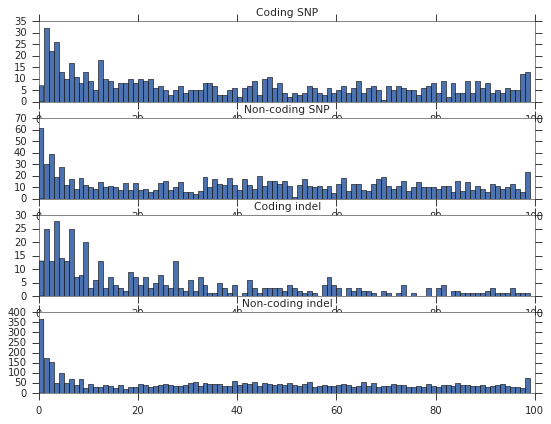

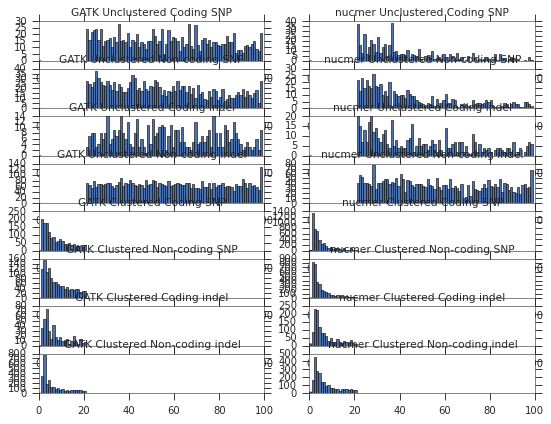

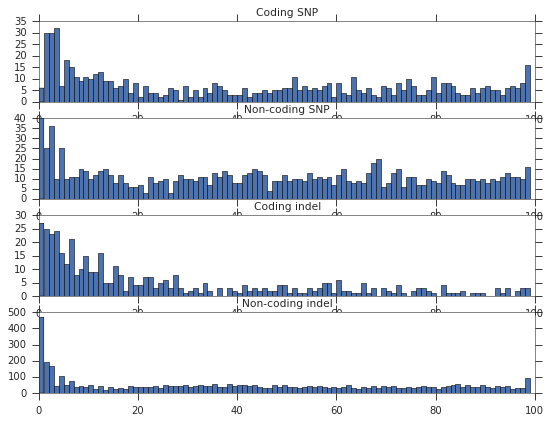

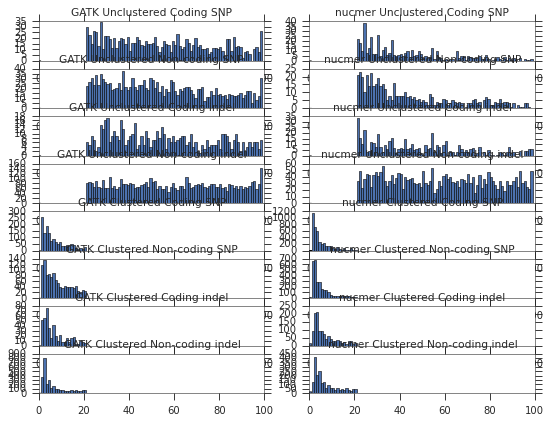

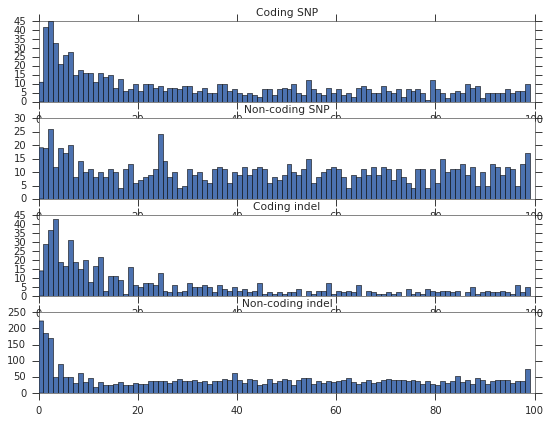

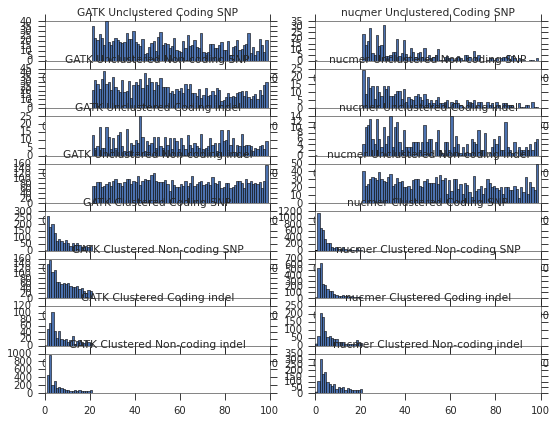

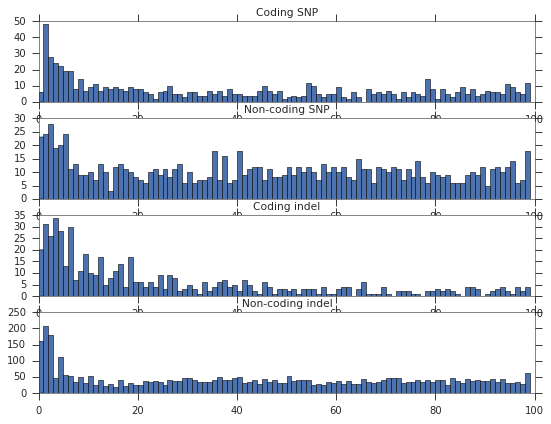

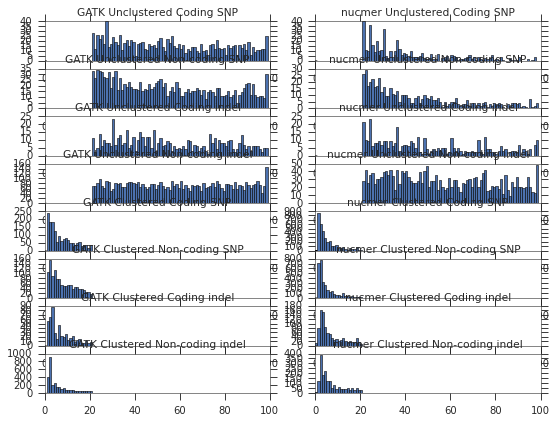

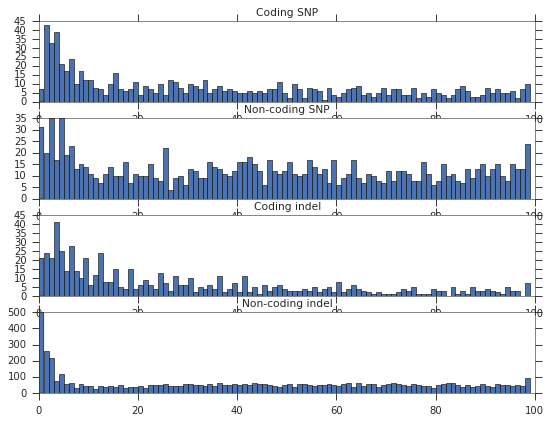

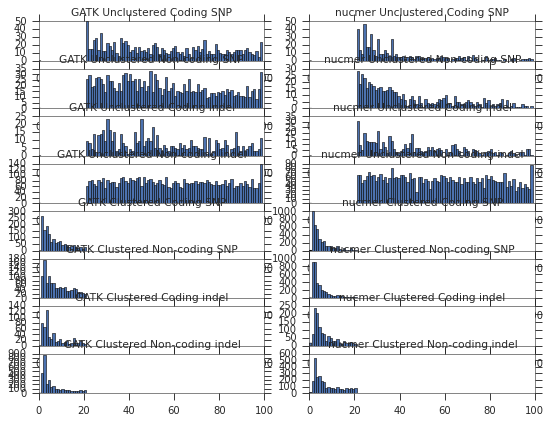

In [270]:
eval_metrics = collections.OrderedDict()
for sample in release4_vcfnp_dir:
    print(sample)
    eval_metrics[sample], _, _ = run_fdr_pipeline(sample, rewrite=True)

In [283]:
for flt_type in eval_metrics['7G8']:
    FDR = np.zeros(len(eval_metrics))
    sensitivity = np.zeros(len(eval_metrics))
    for i, sample in enumerate(eval_metrics):
        FDR[i] = (eval_metrics[sample][flt_type]['num_FP']/eval_metrics[sample][flt_type]['num_accessible'])
        sensitivity[i] = (eval_metrics[sample][flt_type]['num_TP']/(eval_metrics[sample][flt_type]['num_TP']+eval_metrics[sample][flt_type]['num_FN']))
    print("%s: mean FDR = %6.4f, mean sensitivity = %6.4f" % (flt_type, np.mean(FDR), np.mean(sensitivity)))

Unclustered Coding SNP: mean FDR = 0.0010, mean sensitivity = 0.8526
Unclustered Non-coding SNP: mean FDR = 0.0065, mean sensitivity = 0.7565
Unclustered Coding indel: mean FDR = 0.0053, mean sensitivity = 0.6969
Unclustered Non-coding indel: mean FDR = 0.0154, mean sensitivity = 0.6172
Clustered Coding SNP: mean FDR = 0.0018, mean sensitivity = 0.2570
Clustered Non-coding SNP: mean FDR = 0.0109, mean sensitivity = 0.2702
Clustered Coding indel: mean FDR = 0.0049, mean sensitivity = 0.3029
Clustered Non-coding indel: mean FDR = 0.0055, mean sensitivity = 0.5955


In [272]:
for sample in eval_metrics:
    flt_type = 'Unclustered Coding SNP'
    print("%s %s: #variants=%d, #accessible=%d(%4.2f%%), #TP=%d(%4.2f%%), #FP=%d(FDR=%4.2f%%), #FN=%d(sensitivity=%4.2f%%)" % (
            sample,
            flt_type,
            eval_metrics[sample][flt_type]['num_variants'],
            eval_metrics[sample][flt_type]['num_accessible'],
            (eval_metrics[sample][flt_type]['num_accessible']/eval_metrics[sample][flt_type]['num_variants']) * 100,
            eval_metrics[sample][flt_type]['num_TP'],
            (eval_metrics[sample][flt_type]['num_TP']/eval_metrics[sample][flt_type]['num_accessible']) * 100,
            eval_metrics[sample][flt_type]['num_FP'],
            (eval_metrics[sample][flt_type]['num_FP']/eval_metrics[sample][flt_type]['num_accessible']) * 100,
            eval_metrics[sample][flt_type]['num_FN'],
            (eval_metrics[sample][flt_type]['num_TP']/(eval_metrics[sample][flt_type]['num_TP']+eval_metrics[sample][flt_type]['num_FN'])) * 100
        )
    )


7G8 Unclustered Coding SNP: #variants=4992, #accessible=4921(98.58%), #TP=4919(99.96%), #FP=2(FDR=0.04%), #FN=880(sensitivity=84.82%)
GB4 Unclustered Coding SNP: #variants=4886, #accessible=4820(98.65%), #TP=4814(99.88%), #FP=6(FDR=0.12%), #FN=842(sensitivity=85.11%)
KH02 Unclustered Coding SNP: #variants=5577, #accessible=5507(98.74%), #TP=5499(99.85%), #FP=8(FDR=0.15%), #FN=787(sensitivity=87.48%)
KE01 Unclustered Coding SNP: #variants=5006, #accessible=4931(98.50%), #TP=4928(99.94%), #FP=3(FDR=0.06%), #FN=848(sensitivity=85.32%)
GN01 Unclustered Coding SNP: #variants=4858, #accessible=4781(98.41%), #TP=4776(99.90%), #FP=5(FDR=0.10%), #FN=938(sensitivity=83.58%)


In [273]:
for sample in eval_metrics:
    flt_type = 'Unclustered Non-coding indel'
    print("%s %s: #variants=%d, #accessible=%d(%4.2f%%), #TP=%d(%4.2f%%), #FP=%d(FDR=%4.2f%%), #FN=%d(sensitivity=%4.2f%%)" % (
            sample,
            flt_type,
            eval_metrics[sample][flt_type]['num_variants'],
            eval_metrics[sample][flt_type]['num_accessible'],
            (eval_metrics[sample][flt_type]['num_accessible']/eval_metrics[sample][flt_type]['num_variants']) * 100,
            eval_metrics[sample][flt_type]['num_TP'],
            (eval_metrics[sample][flt_type]['num_TP']/eval_metrics[sample][flt_type]['num_accessible']) * 100,
            eval_metrics[sample][flt_type]['num_FP'],
            (eval_metrics[sample][flt_type]['num_FP']/eval_metrics[sample][flt_type]['num_accessible']) * 100,
            eval_metrics[sample][flt_type]['num_FN'],
            (eval_metrics[sample][flt_type]['num_TP']/(eval_metrics[sample][flt_type]['num_TP']+eval_metrics[sample][flt_type]['num_FN'])) * 100
        )
    )


7G8 Unclustered Non-coding indel: #variants=20243, #accessible=20170(99.64%), #TP=19825(98.29%), #FP=345(FDR=1.71%), #FN=13882(sensitivity=58.82%)
GB4 Unclustered Non-coding indel: #variants=21298, #accessible=21214(99.61%), #TP=20763(97.87%), #FP=451(FDR=2.13%), #FN=13365(sensitivity=60.84%)
KH02 Unclustered Non-coding indel: #variants=23277, #accessible=23188(99.62%), #TP=22979(99.10%), #FP=209(FDR=0.90%), #FN=10644(sensitivity=68.34%)
KE01 Unclustered Non-coding indel: #variants=21215, #accessible=21144(99.67%), #TP=20995(99.30%), #FP=149(FDR=0.70%), #FN=11805(sensitivity=64.01%)
GN01 Unclustered Non-coding indel: #variants=21437, #accessible=21347(99.58%), #TP=20869(97.76%), #FP=478(FDR=2.24%), #FN=16018(sensitivity=56.58%)


7G8
Creating array 7G8
Creating consensus 7G8
Running nucmer 7G8
1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/lustre/scratch110/malaria/rp7/Pf3k/validation5/consensus_alignment/nucmer/7G8.ntref" of length 23305107
# construct suffix tree for sequence of length 23305107
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 233051 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23/mummer /lustre/scratch110/malaria/rp7/Pf3k/validation5/consensus_alignment/nucmer/7G8.ntref 14.26
# reading input file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta" of length 22831828
# matching query-file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta"
# against subject-file 

[vcfnp] 2015-10-13 11:44:11.022275 :: caching is enabled
[vcfnp] 2015-10-13 11:44:11.026301 :: no cache file found
[vcfnp] 2015-10-13 11:44:11.027001 :: building array
[vcfnp] 2015-10-13 11:44:11.539324 :: 10000 rows in 0.50s; batch in 0.50s (19853 rows/s)
[vcfnp] 2015-10-13 11:44:12.051749 :: 20000 rows in 1.02s; batch in 0.51s (19514 rows/s)
[vcfnp] 2015-10-13 11:44:12.203977 :: 23066 rows in 1.17s (19742 rows/s)
[vcfnp] 2015-10-13 11:44:12.205958 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/validation5/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf 7G8
Create array of nucmer vcf 7G8
Determining closest nucmer calls 7G8
Determing accessibility 7G8
Characterising variants 7G8
Plotting histogram of distances 7G8
Unclustered Coding SNP: #variants=5292, #accessible=5219(98.62%), #TP=5216(99.94%), #FP=3(FDR=0.06%), #FN=626(sensitivity=89.28%)
Unclustered Non-coding SNP: #variants=4050, #accessible=4013(99.09%), #TP=3975(99.05%), #FP=38(FDR=0.95%), #FN=950(sensitivity=80.71%)
Unclustered Coding indel: #variants=3188, #accessible=3162(99.18%), #TP=3156(99.81%), #FP=6(FDR=0.19%), #FN=1106(sensitivity=74.05%)
Unclustered Non-coding indel: #variants=23083, #accessible=22987(99.58%), #TP=22755(98.99%), #FP=232(FDR=1.01%), #FN=10338(sensitivity=68.76%)
Clustered Coding SNP: #variants=1934, #accessible=1839(95.09%), #TP=1835(99.78%), #FP=4(FDR=0.22%), #FN=4051(sensitivity=31.18%)
Clustered Non-coding SNP: #variants=1858, #accessible=1839(98.98%), #TP=1827(99.35%), #FP=12(FDR=0.65%), #FN=3012(sensitivity=37.76%)
Clust

[vcfnp] 2015-10-13 11:53:22.049501 :: caching is enabled
[vcfnp] 2015-10-13 11:53:22.054257 :: no cache file found
[vcfnp] 2015-10-13 11:53:22.054734 :: building array
[vcfnp] 2015-10-13 11:53:22.628166 :: 10000 rows in 0.57s; batch in 0.57s (17636 rows/s)
[vcfnp] 2015-10-13 11:53:23.203488 :: 20000 rows in 1.14s; batch in 0.58s (17381 rows/s)
[vcfnp] 2015-10-13 11:53:23.248481 :: 20821 rows in 1.19s (17536 rows/s)
[vcfnp] 2015-10-13 11:53:23.250068 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/validation5/consensus_alignment/nucmer/GB4.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf GB4
Create array of nucmer vcf GB4
Determining closest nucmer calls GB4
Determing accessibility GB4
Characterising variants GB4
Plotting histogram of distances GB4
Unclustered Coding SNP: #variants=5206, #accessible=5137(98.67%), #TP=5123(99.73%), #FP=14(FDR=0.27%), #FN=572(sensitivity=89.96%)
Unclustered Non-coding SNP: #variants=4046, #accessible=4019(99.33%), #TP=3979(99.00%), #FP=40(FDR=1.00%), #FN=840(sensitivity=82.57%)
Unclustered Coding indel: #variants=3153, #accessible=3131(99.30%), #TP=3118(99.58%), #FP=13(FDR=0.42%), #FN=1093(sensitivity=74.04%)
Unclustered Non-coding indel: #variants=24582, #accessible=24485(99.61%), #TP=24165(98.69%), #FP=320(FDR=1.31%), #FN=9277(sensitivity=72.26%)
Clustered Coding SNP: #variants=1942, #accessible=1813(93.36%), #TP=1808(99.72%), #FP=5(FDR=0.28%), #FN=3939(sensitivity=31.46%)
Clustered Non-coding SNP: #variants=1888, #accessible=1868(98.94%), #TP=1848(98.93%), #FP=20(FDR=1.07%), #FN=2482(sensitivity=42.68%)
Clus

[vcfnp] 2015-10-13 12:01:31.183773 :: caching is enabled
[vcfnp] 2015-10-13 12:01:31.188288 :: no cache file found
[vcfnp] 2015-10-13 12:01:31.189178 :: building array
[vcfnp] 2015-10-13 12:01:31.758379 :: 10000 rows in 0.56s; batch in 0.56s (17862 rows/s)
[vcfnp] 2015-10-13 12:01:32.248283 :: 18186 rows in 1.05s (17324 rows/s)
[vcfnp] 2015-10-13 12:01:32.250025 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/validation5/consensus_alignment/nucmer/KH02.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf KH02
Create array of nucmer vcf KH02
Determining closest nucmer calls KH02
Determing accessibility KH02
Characterising variants KH02
Plotting histogram of distances KH02
Unclustered Coding SNP: #variants=5911, #accessible=5837(98.75%), #TP=5832(99.91%), #FP=5(FDR=0.09%), #FN=501(sensitivity=92.09%)
Unclustered Non-coding SNP: #variants=4305, #accessible=4273(99.26%), #TP=4242(99.27%), #FP=31(FDR=0.73%), #FN=721(sensitivity=85.47%)
Unclustered Coding indel: #variants=3522, #accessible=3488(99.03%), #TP=3482(99.83%), #FP=6(FDR=0.17%), #FN=867(sensitivity=80.06%)
Unclustered Non-coding indel: #variants=25782, #accessible=25669(99.56%), #TP=25475(99.24%), #FP=194(FDR=0.76%), #FN=7267(sensitivity=77.81%)
Clustered Coding SNP: #variants=2348, #accessible=2259(96.21%), #TP=2252(99.69%), #FP=7(FDR=0.31%), #FN=4446(sensitivity=33.62%)
Clustered Non-coding SNP: #variants=2243, #accessible=2219(98.93%), #TP=2208(99.50%), #FP=11(FDR=0.50%), #FN=2292(sensitivity=49.07%)
C

[vcfnp] 2015-10-13 12:09:31.638489 :: caching is enabled
[vcfnp] 2015-10-13 12:09:31.643767 :: no cache file found
[vcfnp] 2015-10-13 12:09:31.644264 :: building array
[vcfnp] 2015-10-13 12:09:32.195881 :: 10000 rows in 0.55s; batch in 0.55s (18329 rows/s)
[vcfnp] 2015-10-13 12:09:32.545833 :: 16386 rows in 0.90s (18297 rows/s)
[vcfnp] 2015-10-13 12:09:32.547661 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/validation5/consensus_alignment/nucmer/KE01.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf KE01
Create array of nucmer vcf KE01
Determining closest nucmer calls KE01
Determing accessibility KE01
Characterising variants KE01
Plotting histogram of distances KE01
Unclustered Coding SNP: #variants=5375, #accessible=5297(98.55%), #TP=5290(99.87%), #FP=7(FDR=0.13%), #FN=503(sensitivity=91.32%)
Unclustered Non-coding SNP: #variants=4151, #accessible=4118(99.21%), #TP=4096(99.47%), #FP=22(FDR=0.53%), #FN=813(sensitivity=83.44%)
Unclustered Coding indel: #variants=3380, #accessible=3363(99.50%), #TP=3354(99.73%), #FP=9(FDR=0.27%), #FN=879(sensitivity=79.23%)
Unclustered Non-coding indel: #variants=25548, #accessible=25455(99.64%), #TP=25294(99.37%), #FP=161(FDR=0.63%), #FN=6590(sensitivity=79.33%)
Clustered Coding SNP: #variants=2312, #accessible=2188(94.64%), #TP=2182(99.73%), #FP=6(FDR=0.27%), #FN=2930(sensitivity=42.68%)
Clustered Non-coding SNP: #variants=2124, #accessible=2108(99.25%), #TP=2098(99.53%), #FP=10(FDR=0.47%), #FN=2674(sensitivity=43.96%)
C

[vcfnp] 2015-10-13 12:18:29.756517 :: caching is enabled
[vcfnp] 2015-10-13 12:18:29.760765 :: no cache file found
[vcfnp] 2015-10-13 12:18:29.761358 :: building array
[vcfnp] 2015-10-13 12:18:30.489472 :: 10000 rows in 0.72s; batch in 0.72s (13947 rows/s)
[vcfnp] 2015-10-13 12:18:31.132515 :: 20000 rows in 1.36s; batch in 0.64s (15550 rows/s)
[vcfnp] 2015-10-13 12:18:31.303587 :: 22583 rows in 1.53s (14749 rows/s)
[vcfnp] 2015-10-13 12:18:31.306368 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/validation5/consensus_alignment/nucmer/GN01.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf GN01
Create array of nucmer vcf GN01
Determining closest nucmer calls GN01
Determing accessibility GN01
Characterising variants GN01
Plotting histogram of distances GN01
Unclustered Coding SNP: #variants=5280, #accessible=5196(98.41%), #TP=5182(99.73%), #FP=14(FDR=0.27%), #FN=525(sensitivity=90.80%)
Unclustered Non-coding SNP: #variants=4163, #accessible=4136(99.35%), #TP=4077(98.57%), #FP=59(FDR=1.43%), #FN=793(sensitivity=83.72%)
Unclustered Coding indel: #variants=3399, #accessible=3375(99.29%), #TP=3368(99.79%), #FP=7(FDR=0.21%), #FN=1113(sensitivity=75.16%)
Unclustered Non-coding indel: #variants=25890, #accessible=25773(99.55%), #TP=25372(98.44%), #FP=401(FDR=1.56%), #FN=10699(sensitivity=70.34%)
Clustered Coding SNP: #variants=2126, #accessible=1994(93.79%), #TP=1993(99.95%), #FP=1(FDR=0.05%), #FN=3229(sensitivity=38.17%)
Clustered Non-coding SNP: #variants=2090, #accessible=2074(99.23%), #TP=2055(99.08%), #FP=19(FDR=0.92%), #FN=3310(sensitivity=38.30%

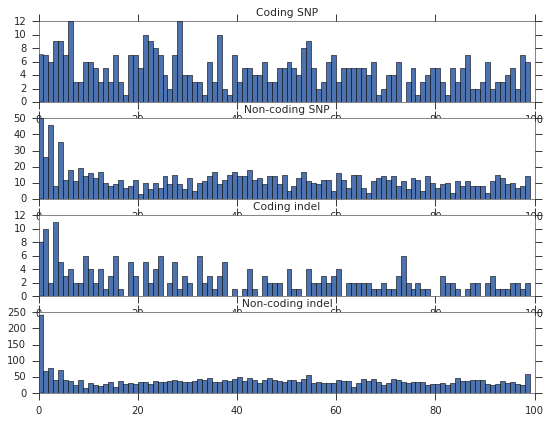

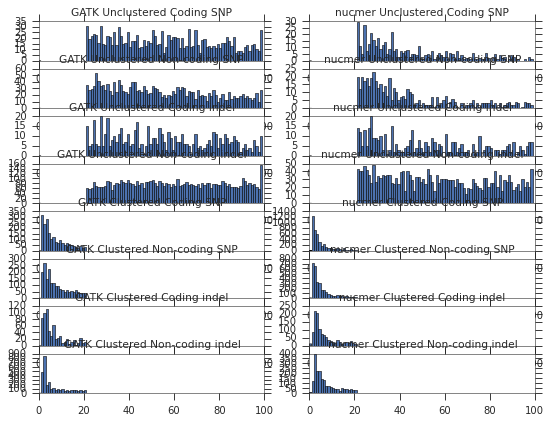

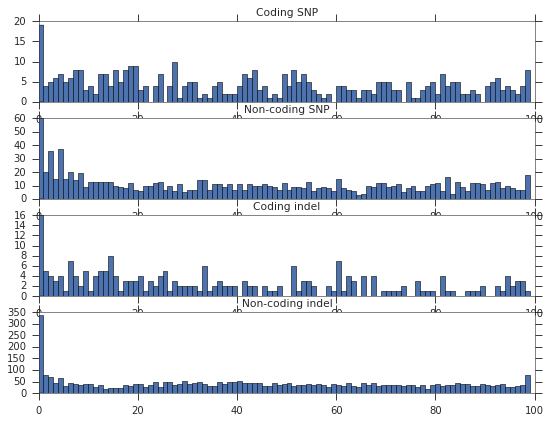

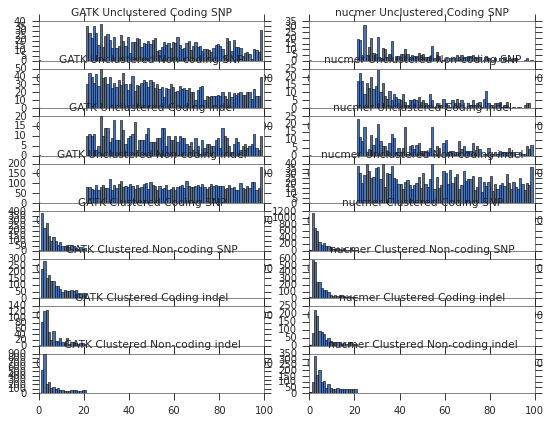

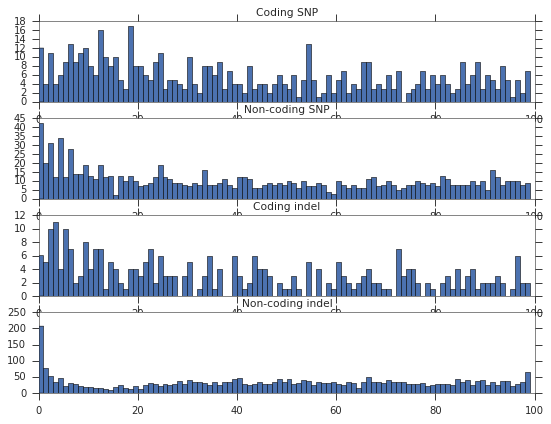

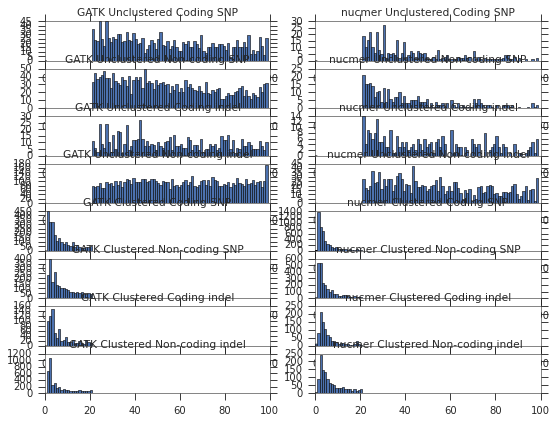

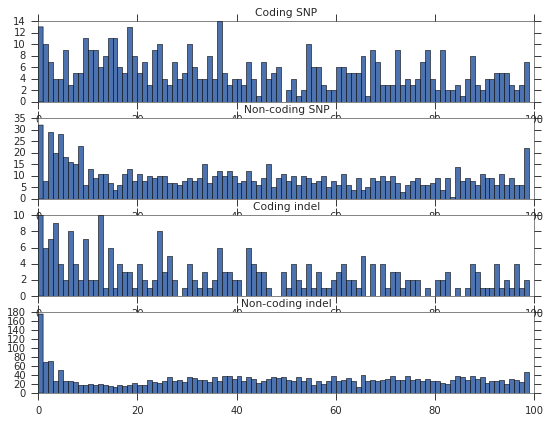

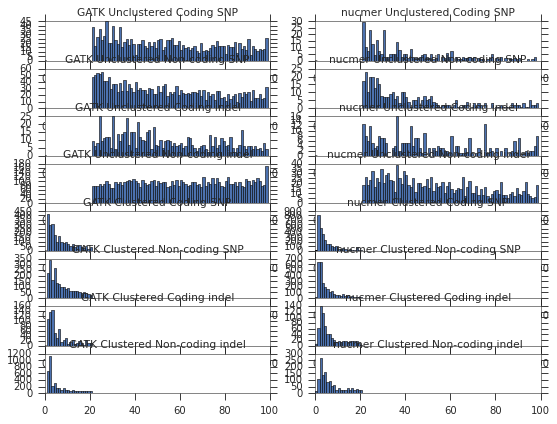

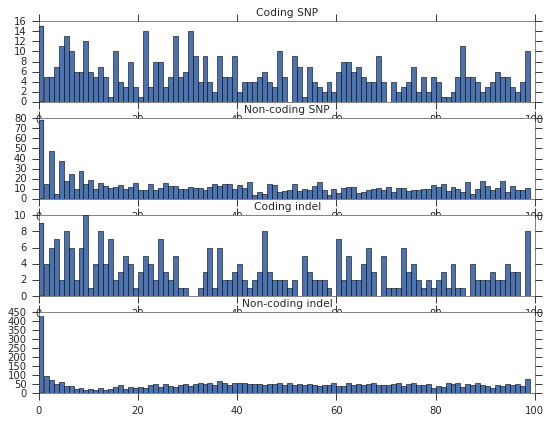

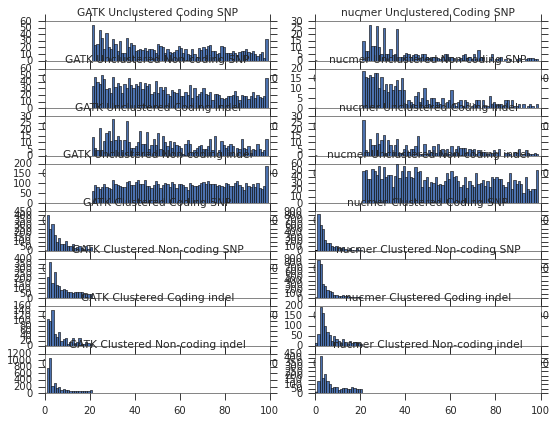

In [275]:
eval_metrics_validation5 = collections.OrderedDict()
for sample in validation5_vcfnp_dir:
    print(sample)
    eval_metrics_validation5[sample], _, _ = run_fdr_pipeline(
        sample,
        vcfnp_dir_dict=validation5_vcfnp_dir,
        consensus_dir='/lustre/scratch110/malaria/rp7/Pf3k/validation5/consensus_alignment',
        rewrite=False
    )
    

In [276]:
for sample in eval_metrics_validation5:
    flt_type = 'Unclustered Coding SNP'
    print("%s %s: #variants=%d, #accessible=%d(%4.2f%%), #TP=%d(%4.2f%%), #FP=%d(FDR=%4.2f%%), #FN=%d(sensitivity=%4.2f%%)" % (
            sample,
            flt_type,
            eval_metrics_validation5[sample][flt_type]['num_variants'],
            eval_metrics_validation5[sample][flt_type]['num_accessible'],
            (eval_metrics_validation5[sample][flt_type]['num_accessible']/eval_metrics_validation5[sample][flt_type]['num_variants']) * 100,
            eval_metrics_validation5[sample][flt_type]['num_TP'],
            (eval_metrics_validation5[sample][flt_type]['num_TP']/eval_metrics_validation5[sample][flt_type]['num_accessible']) * 100,
            eval_metrics_validation5[sample][flt_type]['num_FP'],
            (eval_metrics_validation5[sample][flt_type]['num_FP']/eval_metrics_validation5[sample][flt_type]['num_accessible']) * 100,
            eval_metrics_validation5[sample][flt_type]['num_FN'],
            (eval_metrics_validation5[sample][flt_type]['num_TP']/(eval_metrics_validation5[sample][flt_type]['num_TP']+eval_metrics_validation5[sample][flt_type]['num_FN'])) * 100
        )
    )


7G8 Unclustered Coding SNP: #variants=5292, #accessible=5219(98.62%), #TP=5216(99.94%), #FP=3(FDR=0.06%), #FN=626(sensitivity=89.28%)
GB4 Unclustered Coding SNP: #variants=5206, #accessible=5137(98.67%), #TP=5123(99.73%), #FP=14(FDR=0.27%), #FN=572(sensitivity=89.96%)
KH02 Unclustered Coding SNP: #variants=5911, #accessible=5837(98.75%), #TP=5832(99.91%), #FP=5(FDR=0.09%), #FN=501(sensitivity=92.09%)
KE01 Unclustered Coding SNP: #variants=5375, #accessible=5297(98.55%), #TP=5290(99.87%), #FP=7(FDR=0.13%), #FN=503(sensitivity=91.32%)
GN01 Unclustered Coding SNP: #variants=5280, #accessible=5196(98.41%), #TP=5182(99.73%), #FP=14(FDR=0.27%), #FN=525(sensitivity=90.80%)


In [277]:
for sample in eval_metrics_validation5:
    flt_type = 'Unclustered Non-coding indel'
    print("%s %s: #variants=%d, #accessible=%d(%4.2f%%), #TP=%d(%4.2f%%), #FP=%d(FDR=%4.2f%%), #FN=%d(sensitivity=%4.2f%%)" % (
            sample,
            flt_type,
            eval_metrics_validation5[sample][flt_type]['num_variants'],
            eval_metrics_validation5[sample][flt_type]['num_accessible'],
            (eval_metrics_validation5[sample][flt_type]['num_accessible']/eval_metrics_validation5[sample][flt_type]['num_variants']) * 100,
            eval_metrics_validation5[sample][flt_type]['num_TP'],
            (eval_metrics_validation5[sample][flt_type]['num_TP']/eval_metrics_validation5[sample][flt_type]['num_accessible']) * 100,
            eval_metrics_validation5[sample][flt_type]['num_FP'],
            (eval_metrics_validation5[sample][flt_type]['num_FP']/eval_metrics_validation5[sample][flt_type]['num_accessible']) * 100,
            eval_metrics_validation5[sample][flt_type]['num_FN'],
            (eval_metrics_validation5[sample][flt_type]['num_TP']/(eval_metrics_validation5[sample][flt_type]['num_TP']+eval_metrics_validation5[sample][flt_type]['num_FN'])) * 100
        )
    )


7G8 Unclustered Non-coding indel: #variants=23083, #accessible=22987(99.58%), #TP=22755(98.99%), #FP=232(FDR=1.01%), #FN=10338(sensitivity=68.76%)
GB4 Unclustered Non-coding indel: #variants=24582, #accessible=24485(99.61%), #TP=24165(98.69%), #FP=320(FDR=1.31%), #FN=9277(sensitivity=72.26%)
KH02 Unclustered Non-coding indel: #variants=25782, #accessible=25669(99.56%), #TP=25475(99.24%), #FP=194(FDR=0.76%), #FN=7267(sensitivity=77.81%)
KE01 Unclustered Non-coding indel: #variants=25548, #accessible=25455(99.64%), #TP=25294(99.37%), #FP=161(FDR=0.63%), #FN=6590(sensitivity=79.33%)
GN01 Unclustered Non-coding indel: #variants=25890, #accessible=25773(99.55%), #TP=25372(98.44%), #FP=401(FDR=1.56%), #FN=10699(sensitivity=70.34%)


In [284]:
for flt_type in eval_metrics_validation5['7G8']:
    FDR = np.zeros(len(eval_metrics_validation5))
    sensitivity = np.zeros(len(eval_metrics_validation5))
    for i, sample in enumerate(eval_metrics_validation5):
        FDR[i] = (eval_metrics_validation5[sample][flt_type]['num_FP']/eval_metrics_validation5[sample][flt_type]['num_accessible'])
        sensitivity[i] = (eval_metrics_validation5[sample][flt_type]['num_TP']/(eval_metrics_validation5[sample][flt_type]['num_TP']+eval_metrics_validation5[sample][flt_type]['num_FN']))
    print("%s: mean FDR = %6.4f, mean sensitivity = %6.4f" % (flt_type, np.mean(FDR), np.mean(sensitivity)))

Unclustered Coding SNP: mean FDR = 0.0016, mean sensitivity = 0.9069
Unclustered Non-coding SNP: mean FDR = 0.0093, mean sensitivity = 0.8318
Unclustered Coding indel: mean FDR = 0.0025, mean sensitivity = 0.7651
Unclustered Non-coding indel: mean FDR = 0.0105, mean sensitivity = 0.7370
Clustered Coding SNP: mean FDR = 0.0023, mean sensitivity = 0.3542
Clustered Non-coding SNP: mean FDR = 0.0072, mean sensitivity = 0.4235
Clustered Coding indel: mean FDR = 0.0025, mean sensitivity = 0.4180
Clustered Non-coding indel: mean FDR = 0.0044, mean sensitivity = 0.6814


Creating array 7G8
Creating consensus 7G8
Running nucmer 7G8

[vcfnp] 2015-10-13 10:43:02.825081 :: caching is enabled
[vcfnp] 2015-10-13 10:43:02.827565 :: cache file available
[vcfnp] 2015-10-13 10:43:02.828034 :: loading from cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy



Coverting nucmer output to vcf 7G8
Converting nucmer vcf coordinates 7G8 False
Annotate nucmer vcf 7G8
Create array of nucmer vcf 7G8
Create array of nucmer vcf 7G8
Determining closest nucmer calls 7G8
Determing accessibility 7G8
Characterising variants 7G8
Plotting histogram of distances 7G8
Unclustered Coding SNP: #variants=4992, #accessible=3643(72.98%), #TP=3643(100.00%), #FP=0(FDR=0.00%), #FN=645(sensitivity=84.96%)
Unclustered Non-coding SNP: #variants=3424, #accessible=2423(70.77%), #TP=2406(99.30%), #FP=17(FDR=0.70%), #FN=689(sensitivity=77.74%)
Unclustered Coding indel: #variants=3033, #accessible=2243(73.95%), #TP=2234(99.60%), #FP=9(FDR=0.40%), #FN=858(sensitivity=72.25%)
Unclustered Non-coding indel: #variants=20243, #accessible=14376(71.02%), #TP=14136(98.33%), #FP=240(FDR=1.67%), #FN=9463(sensitivity=59.90%)
Clustered Coding SNP: #variants=1423, #accessible=796(55.94%), #TP=795(99.87%), #FP=1(FDR=0.13%), #FN=2604(sensitivity=23.39%)
Clustered Non-coding SNP: #variants=12

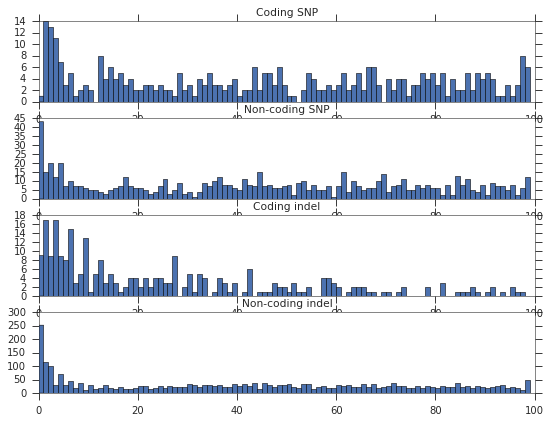

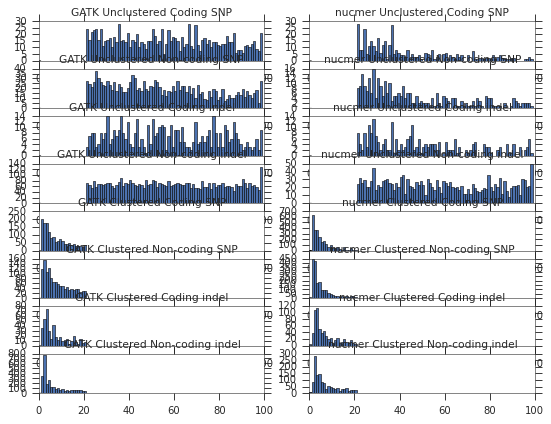

In [262]:
eval_metrics, temp, temp2 = run_fdr_pipeline(rewrite=False)

In [265]:
eval_metrics['Unclustered Coding SNP']

OrderedDict([('num_variants', 4992), ('num_accessible', 3643), ('num_FP', 0), ('num_TP', 3643), ('num_FN', 645)])

Creating array 7G8
Creating consensus 7G8
Running nucmer 7G8
1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref" of length 23285275
# construct suffix tree for sequence of length 23285275
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 232852 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23/mummer /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref 16.16
# reading input file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta" of length 22831828
# matching query-file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta"
# against sub

[vcfnp] 2015-10-13 10:42:34.534094 :: caching is enabled
[vcfnp] 2015-10-13 10:42:34.536231 :: cache file out of date
[vcfnp] 2015-10-13 10:42:34.537176 :: building array
[vcfnp] 2015-10-13 10:42:35.273433 :: 10000 rows in 0.70s; batch in 0.70s (14372 rows/s)
[vcfnp] 2015-10-13 10:42:35.746372 :: 17933 rows in 1.17s (15344 rows/s)
[vcfnp] 2015-10-13 10:42:35.749898 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf 7G8
Create array of nucmer vcf 7G8
Determining closest nucmer calls 7G8
Determing accessibility 7G8
Characterising variants 7G8
Plotting histogram of distances 7G8
Unclustered Coding SNP: #variants=4992, #accessible=3643(72.98%), #TP=3643(100.00%), #FP=0(FDR=0.00%), #FN=645(sensitivity=84.96%)
Unclustered Non-coding SNP: #variants=3424, #accessible=2423(70.77%), #TP=2406(99.30%), #FP=17(FDR=0.70%), #FN=689(sensitivity=77.74%)
Unclustered Coding indel: #variants=3033, #accessible=2243(73.95%), #TP=2234(99.60%), #FP=9(FDR=0.40%), #FN=858(sensitivity=72.25%)
Unclustered Non-coding indel: #variants=20243, #accessible=14376(71.02%), #TP=14136(98.33%), #FP=240(FDR=1.67%), #FN=9463(sensitivity=59.90%)
Clustered Coding SNP: #variants=1423, #accessible=796(55.94%), #TP=795(99.87%), #FP=1(FDR=0.13%), #FN=2604(sensitivity=23.39%)
Clustered Non-coding SNP: #variants=1203, #accessible=762(63.34%), #TP=736(96.59%), #FP=26(FDR=3.41%), #FN=1819(sensitivity=28.81%)
Clustered 

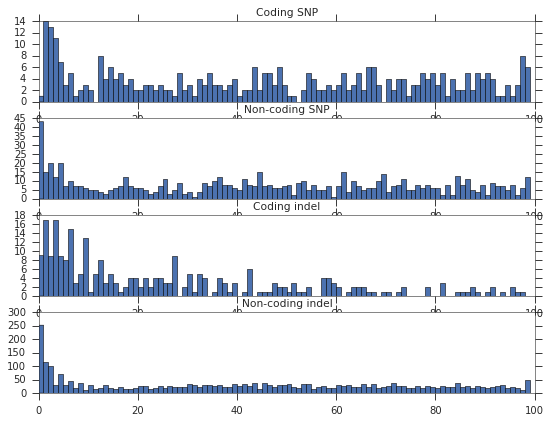

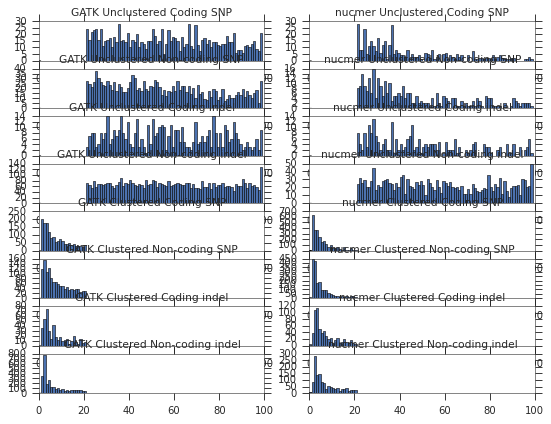

In [259]:
temp, temp2 = run_fdr_pipeline(rewrite=True)

In [230]:
temp_alt = np.array([len(x['REF'])-len(x['ALT'][0]) for x in temp2])
temp_is_snp = np.array([(len(x['REF'])-len(x['ALT'][0])) == 0 for x in temp2])
np.unique(temp_alt==0, return_counts=True)
np.unique(temp_is_snp, return_counts=True)

(array([False,  True], dtype=bool), array([18751, 10090]))

Creating array 7G8
Creating consensus 7G8
Running nucmer 7G8
1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref" of length 23279732
# construct suffix tree for sequence of length 23279732
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 232797 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23/mummer /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref 13.52
# reading input file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta" of length 22831828
# matching query-file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta"
# against sub

[vcfnp] 2015-10-12 16:57:18.519549 :: caching is enabled
[vcfnp] 2015-10-12 16:57:18.521900 :: cache file out of date
[vcfnp] 2015-10-12 16:57:18.522487 :: building array
[vcfnp] 2015-10-12 16:57:19.039761 :: 10000 rows in 0.51s; batch in 0.51s (19602 rows/s)
[vcfnp] 2015-10-12 16:57:19.438390 :: 18050 rows in 0.91s (19861 rows/s)
[vcfnp] 2015-10-12 16:57:19.440822 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf 7G8
Determining closest nucmer calls 7G8
Determing accessibility 7G8
Plotting histogram of distances 7G8
Coding SNP: #variants=5151, #0bp=29(0.56%), #10bp=53(1.03%)
Non-coding SNP: #variants=3796, #0bp=111(2.92%), #10bp=263(6.93%)
Coding indel: #variants=3506, #0bp=39(1.11%), #10bp=109(3.11%)
Non-coding indel: #variants=19240, #0bp=397(2.06%), #10bp=977(5.08%)
Plotting histogram of distances 7G8
Plotting histogram of distances 7G8
Plotting histogram of distances 7G8


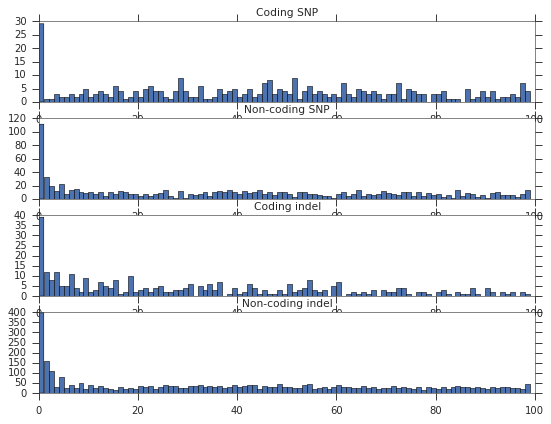

In [205]:
temp = run_fdr_pipeline(vqslod_threshold=-10.0, rewrite=True)

Creating array 7G8
Creating consensus 7G8
Running nucmer 7G8
1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref" of length 23319464
# construct suffix tree for sequence of length 23319464
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 233194 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23/mummer /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref 13.71
# reading input file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta" of length 22831828
# matching query-file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta"
# against sub

[vcfnp] 2015-10-12 17:10:54.433906 :: caching is enabled
[vcfnp] 2015-10-12 17:10:54.437291 :: cache file out of date
[vcfnp] 2015-10-12 17:10:54.438060 :: building array
[vcfnp] 2015-10-12 17:10:54.924323 :: 9251 rows in 0.48s (19292 rows/s)
[vcfnp] 2015-10-12 17:10:54.926728 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf 7G8
Determining closest nucmer calls 7G8
Determing accessibility 7G8
Plotting histogram of distances 7G8
Coding SNP: #variants=1393, #0bp=1(0.07%), #10bp=19(1.36%)
Non-coding SNP: #variants=699, #0bp=2(0.29%), #10bp=21(3.00%)
Coding indel: #variants=84, #0bp=0(0.00%), #10bp=6(7.14%)
Non-coding indel: #variants=2894, #0bp=60(2.07%), #10bp=196(6.77%)
Plotting histogram of distances 7G8
Plotting histogram of distances 7G8
Plotting histogram of distances 7G8


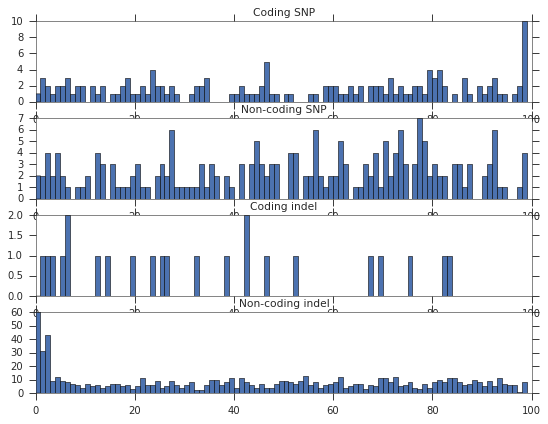

In [206]:
temp = run_fdr_pipeline(vqslod_threshold=6.0, rewrite=True)

Creating array 7G8
Creating consensus 7G8
Running nucmer 7G8
1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref" of length 23285275
# construct suffix tree for sequence of length 23285275
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 232852 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23/mummer /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref 13.52
# reading input file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta" of length 22831828
# matching query-file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta"
# against sub

[vcfnp] 2015-10-13 09:34:01.552137 :: caching is enabled
[vcfnp] 2015-10-13 09:34:01.554501 :: cache file out of date
[vcfnp] 2015-10-13 09:34:01.555065 :: building array
[vcfnp] 2015-10-13 09:34:02.136124 :: 10000 rows in 0.57s; batch in 0.57s (17442 rows/s)
[vcfnp] 2015-10-13 09:34:02.656690 :: 20000 rows in 1.09s; batch in 0.52s (19209 rows/s)
[vcfnp] 2015-10-13 09:34:03.072230 :: 28165 rows in 1.51s (18659 rows/s)
[vcfnp] 2015-10-13 09:34:03.075055 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf 7G8
Determining closest nucmer calls 7G8
Determing accessibility 7G8
Characterising variants 7G8
Coding SNP: #variants=6415, #accessible=6213(96.85%), #0bp=7(0.11%), #10bp=167(2.69%)
Non-coding SNP: #variants=4627, #accessible=4446(96.09%), #0bp=61(1.37%), #10bp=242(5.44%)
Coding indel: #variants=3436, #accessible=3391(98.69%), #0bp=13(0.38%), #10bp=167(4.92%)
Non-coding indel: #variants=22920, #accessible=22583(98.53%), #0bp=359(1.59%), #10bp=1102(4.88%)
Plotting histogram of distances 7G8
Coding SNP: #variants=6415, #accessible=6213(96.85%), #TP=6206(99.89%), #FP=7(FDR=0.11%), #FN=5495(sensitivity=53.04%)
Non-coding SNP: #variants=4627, #accessible=4446(96.09%), #TP=4385(98.63%), #FP=61(FDR=1.37%), #FN=4254(sensitivity=50.76%)
Coding indel: #variants=3436, #accessible=3391(98.69%), #TP=3378(99.62%), #FP=13(FDR=0.38%), #FN=2554(sensitivity=56.95%)
Non-coding indel: #variants=22920, #accessible=22583(98.53%), #TP=22224(98.41%), #FP=359(FDR=1.59%), #FN=15862(s

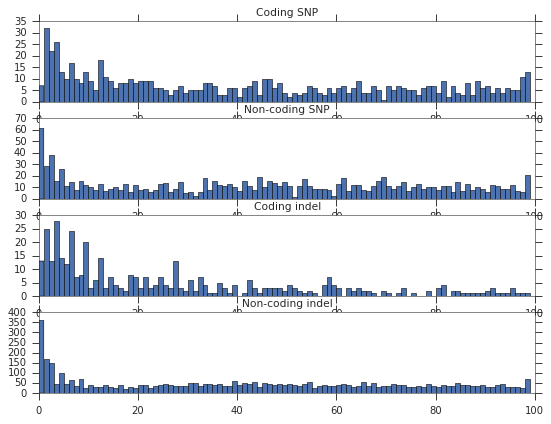

In [238]:
temp, temp2 = run_fdr_pipeline(delta_filter_i=98, rewrite=True)

Creating array 7G8
Creating consensus 7G8
Running nucmer 7G8
1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref" of length 23285275
# construct suffix tree for sequence of length 23285275
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 232852 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/mummer/MUMmer3.23/mummer /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.ntref 16.42
# reading input file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta" of length 22831828
# matching query-file "/nfs/pathogen003/tdo/Pfalciparum/PF3K/Reference12Genomes/ReleaseJul/Pf7G8.Jul2015.fasta"
# against sub

[vcfnp] 2015-10-13 09:42:42.270289 :: caching is enabled
[vcfnp] 2015-10-13 09:42:42.273166 :: cache file out of date
[vcfnp] 2015-10-13 09:42:42.273831 :: building array
[vcfnp] 2015-10-13 09:42:42.840424 :: 10000 rows in 0.56s; batch in 0.56s (17919 rows/s)
[vcfnp] 2015-10-13 09:42:43.401743 :: 20000 rows in 1.12s; batch in 0.56s (17814 rows/s)
[vcfnp] 2015-10-13 09:42:43.885051 :: 28841 rows in 1.60s (17995 rows/s)
[vcfnp] 2015-10-13 09:42:43.887753 :: saving to cache file /lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/consensus_alignment/nucmer/7G8.3d7coordinates.annotated.vcf.gz.vcfnp_cache/variants.npy


Create array of nucmer vcf 7G8
Determining closest nucmer calls 7G8
Determing accessibility 7G8
Characterising variants 7G8
Coding SNP: #variants=6415, #accessible=6275(97.82%), #0bp=7(0.11%), #10bp=168(2.68%)
Non-coding SNP: #variants=4627, #accessible=4576(98.90%), #0bp=61(1.33%), #10bp=255(5.57%)
Coding indel: #variants=3436, #accessible=3413(99.33%), #0bp=13(0.38%), #10bp=169(4.95%)
Non-coding indel: #variants=22920, #accessible=22833(99.62%), #0bp=364(1.59%), #10bp=1131(4.95%)
Plotting histogram of distances 7G8
Coding SNP: #variants=6415, #accessible=6275(97.82%), #TP=6268(99.89%), #FP=7(FDR=0.11%), #FN=5526(sensitivity=53.15%)
Non-coding SNP: #variants=4627, #accessible=4576(98.90%), #TP=4515(98.67%), #FP=61(FDR=1.33%), #FN=4564(sensitivity=49.73%)
Coding indel: #variants=3436, #accessible=3413(99.33%), #TP=3400(99.62%), #FP=13(FDR=0.38%), #FN=2637(sensitivity=56.32%)
Non-coding indel: #variants=22920, #accessible=22833(99.62%), #TP=22469(98.41%), #FP=364(FDR=1.59%), #FN=16114(s

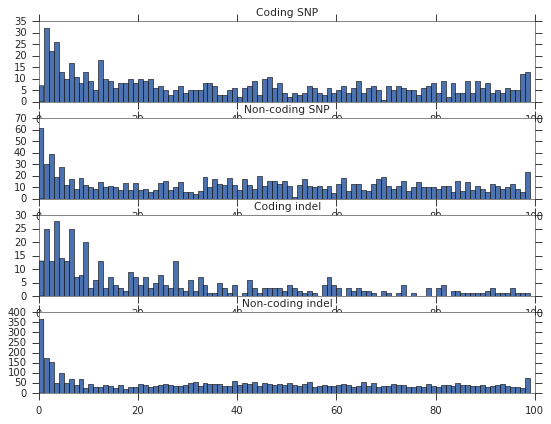

In [239]:
temp, temp2 = run_fdr_pipeline(delta_filter_i=97, rewrite=True)

(array([ 310.,  166.,  149.,   73.,  109.,   54.,   75.,   31.,   54.,
          37.,   41.,   30.,   41.,   41.,   36.,   29.,   39.,   34.,
          31.,   32.,   39.,   37.,   27.,   30.,   46.,   38.,   39.,
          39.,   38.,   32.,   45.,   34.,   39.,   47.,   43.,   41.,
          51.,   36.,   37.,   47.,   33.,   47.,   43.,   52.,   34.,
          51.,   46.,   36.,   49.,   42.,   45.,   32.,   30.,   47.,
          48.,   29.,   29.,   38.,   34.,   28.,   43.,   48.,   39.,
          38.,   37.,   43.,   37.,   48.,   33.,   38.,   37.,   45.,
          41.,   46.,   25.,   29.,   38.,   30.,   43.,   34.,   30.,
          35.,   34.,   30.,   53.,   34.,   47.,   30.,   37.,   36.,
          28.,   40.,   34.,   39.,   28.,   35.,   26.,   29.,   68.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4

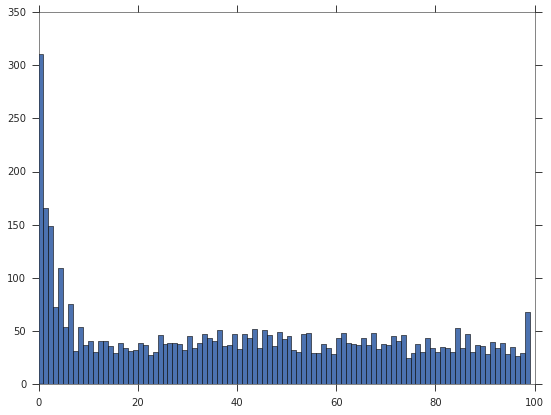

In [175]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist(temp['nearest_nucmer'], bins=np.arange(0, 100))

(array([ 305.,  161.,  143.,   71.,  107.,   48.,   74.,   29.,   51.,
          33.,   37.,   26.,   40.,   39.,   36.,   28.,   36.,   33.,
          30.,   31.,   38.,   37.,   25.,   30.,   42.,   36.,   36.,
          38.,   37.,   29.,   45.,   33.,   37.,   46.,   43.,   39.,
          50.,   34.,   36.,   47.,   32.,   46.,   42.,   51.,   34.,
          50.,   45.,   35.,   45.,   41.,   43.,   30.,   29.,   47.,
          47.,   27.,   28.,   37.,   33.,   26.,   41.,   48.,   38.,
          37.,   36.,   43.,   36.,   45.,   33.,   38.,   34.,   45.,
          39.,   44.,   24.,   26.,   37.,   30.,   41.,   33.,   29.,
          35.,   33.,   29.,   52.,   33.,   45.,   28.,   37.,   36.,
          27.,   39.,   34.,   38.,   28.,   35.,   26.,   28.,   67.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4

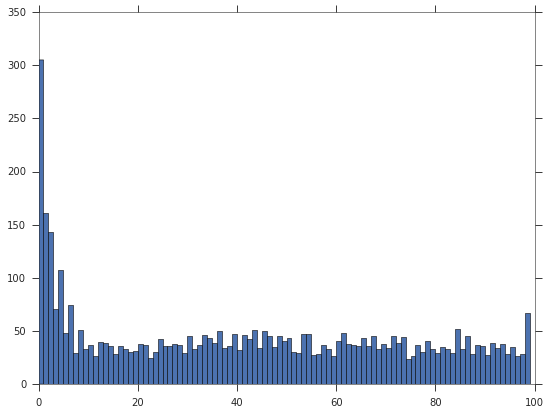

In [179]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist(temp['nearest_nucmer'][temp['is_accessible']], bins=np.arange(0, 100))

In [176]:
len(temp)

37398

In [181]:
print(np.unique(temp['nearest_nucmer'] == 0, return_counts=True))
print(np.unique(temp['nearest_nucmer'] < 0, return_counts=True))
print(np.unique(temp['nearest_nucmer'] > 0, return_counts=True))
print(np.max(temp['nearest_nucmer']))
print(np.max(temp['nearest_nucmer'][temp['is_accessible']]))
print(np.median(temp['nearest_nucmer']))
print(np.median(temp['nearest_nucmer'][temp['is_accessible']]))
print(np.where(temp['nearest_nucmer'] > 50000))

(array([False,  True], dtype=bool), array([37088,   310]))
(array([False], dtype=bool), array([37398]))
(array([False,  True], dtype=bool), array([  310, 37088]))
216400
107571
755.0
408.0
(array([  492,   493,   494, ..., 29835, 29836, 29837]),)


In [183]:
print(np.unique(temp['is_accessible'], return_counts=True))


(array([False,  True], dtype=bool), array([11095, 26303]))


In [120]:
len(temp)

37416

In [121]:
831/37416

0.022209749839640795

In [124]:
36585 + 831 

37416

In [184]:
temp

array([ (b'Pf3D7_01_v3', 93157, b'.', b'T', [b'A', b''], 15310.9296875, (False, False, False, False, False, False, False, False, False, False, False, True), 2, True, 0, [2, 0], [1.0, 0.0], 2, -0.388916015625, 1.33984375, 115, False, 0, 3.14453125, 33.33000183105469, 0.0, 0.0, [0, 0], [0.0, 0.0], 60.0, 3.380859375, True, True, 31.125, [0, 0, 0], b'', 0.0, b'Core', b'', b'', b'INTRAGENIC', b'', b'NONE', b'', b'Gene_PF3D7_0102000', b'MODIFIER', b'', 0.5260000228881836, False, 2.2200000286102295, b'SNP', b'MQRankSum', b'variant', b'A', 9753, False),
       (b'Pf3D7_01_v3', 94257, b'.', b'A', [b'AATAT', b''], 842552.75, (False, False, False, False, False, False, False, False, False, False, False, True), 2, False, 4, [2, 0], [1.0, 0.0], 2, 0.0, 0.133056640625, 23, False, 0, 0.6728515625, 14.289999961853027, 0.0, 0.0, [0, 0], [0.0, 0.0], 60.0, 0.061004638671875, False, False, 24.8125, [5, 6, 7], b'AT', 0.0, b'Core', b'', b'', b'INTERGENIC', b'', b'NONE', b'', b'', b'MODIFIER', b'', 0.78899997

# Sandbox

In [30]:
sample = '7G8'
ref_chroms = ['M76611', 'PFC10_API_IRAB'] + ["Pf3D7_%02d_v3" % i for i in range(1, 15)]
query_chroms = ["Pf%s_MT" % sample, "Pf%s_API" % sample] + ["Pf%s_%02d" % (sample, i) for i in range(1, 15)]
chrom_dict = dict(zip(ref_chroms, query_chroms))


In [31]:
chrom_dict.keys()

dict_keys(['Pf3D7_01_v3', 'Pf3D7_02_v3', 'PFC10_API_IRAB', 'Pf3D7_03_v3', 'Pf3D7_09_v3', 'Pf3D7_07_v3', 'Pf3D7_12_v3', 'Pf3D7_06_v3', 'Pf3D7_13_v3', 'Pf3D7_14_v3', 'Pf3D7_05_v3', 'M76611', 'Pf3D7_04_v3', 'Pf3D7_10_v3', 'Pf3D7_11_v3', 'Pf3D7_08_v3'])

In [83]:
temp=SeqIO.to_dict(SeqIO.parse(open('/lustre/scratch110/malaria/rp7/Pf3k/GATKbuild/Pfalciparum_GeneDB_Aug2015/Pfalciparum.genome.fasta'), "fasta"))

In [86]:
len(temp['Pf3D7_05_v3'])

1343557

In [91]:
temp=SeqIO.to_dict(SeqIO.parse(open('/nfs/users/nfs_r/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/snpeff/snpEff/data/Pfalciparum_GeneDB_Aug2015/sequences.fa'), "fasta"))
len(temp['Pf3D7_05_v3'])

1343557

In [149]:
variants_array = np.load('/lustre/scratch110/malaria/rp7/Pf3k/release4_candidate/vcfnp/WG.7G8.vcf.gz.vcfnp_cache/variants.npy')

In [150]:
variants_array[0]

(b'Pf3D7_01_v3', 211, b'.', b'GAACCCTA', [b'*', b''], 4501.18994140625, (False, False, False, True, False, True, False, False, False, False, False, False), 2, False, -7, [1, 0], [0.5, 0.0], 2, 1.75, -0.406005859375, 18, False, 0, 4.390625, 47.619998931884766, 0.0, 0.0, [0, 0], [0.0, 0.0], 32.625, 0.5498046875, False, False, 29.8125, [0, 0, 0], b'', -0.2548828125, b'SubtelomericRepeat', b'', b'', b'INTERGENIC', b'', b'NONE', b'', b'', b'MODIFIER', b'', 0.3440000116825104, False, -27.3700008392334, b'MULTIALLELIC_MIXED', b'MQ', b'FilteredInAll')